# Проект Интернет-магазин «В один клик»

##### Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

##### Цель исследования
Провести анализ данных и разработать модель машинного обучения, которая позволит получить решение для персонализации предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

##### Этапы исследования

- **Этап 1.** Загрузка, обзор и изучение данных
- **Этап 2.** Предобработка данных: проверка на пропуски, поиск аномалий,при необходимости переименовка и приведение к единому стилю данных
- **Этап 3.** Исследовательский анализ данных: изучение и построение графиков для признаков, выводы на основе этих графиков
- **Этап 4.** Обучение и построение моделей с помощию Pipeline. Выбор лучшейшей модели
- **Этап 5.** Анализ важности признаков с помощью метода SHAP
- **Этап 6.** Произвести сегментацию покупателей. Сделать предложения по увеличению покупательской активности отдельных сегментов
- **Этап 7.** Общие выводы. Обоснование выбора лучейшей модели, предложения по увеличению покупательской активности и сегментации покупателей.


In [94]:
!pip install phik -q
!pip install shap -q
!pip install scikit-learn==1.5.1 -q
!pip install matplotlib==3.7.1 -q

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st 
from matplotlib import pyplot as plt
import seaborn as sns 
import sklearn
from phik import phik_matrix
import shap

In [14]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")


RANDOM_STATE = 42
TEST_SIZE = 0.25

####  Этап 1. Загрузка, обзор и изучение данных

In [15]:
df_clients = pd.read_csv('/Users/zurik/Documents/Yandex Practicum/Data Science/project_teacher/market_file.csv')
df_clients.info()
df_clients.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [16]:
df_money = pd.read_csv('/Users/zurik/Documents/Yandex Practicum/Data Science/project_teacher/market_money.csv')
df_money.info()
df_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [17]:
df_time = pd.read_csv('/Users/zurik/Documents/Yandex Practicum/Data Science/project_teacher/market_time.csv')
df_time.info()
df_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [18]:
df_value = pd.read_csv('/Users/zurik/Documents/Yandex Practicum/Data Science/project_teacher/money.csv', sep=';', decimal=',')
df_value.info()
df_value.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

- Пропуски не обнаружены
- Типы данных в столбцах корректны
- Необходимо привести названия столбцов к единому стилю
- Исправить ошибки в данных
- Проверить на наличие явных и неявных дубликатов

####  Этап 2. Предобработка данных

In [19]:
# переименование столбцов в df_clients
df_clients = df_clients.rename(columns={'id': 'id'
                                       , 'Покупательская активность': 'покупательская_активность'
                                       , 'Тип сервиса': 'тип_сервиса'
                                       , 'Разрешить сообщать': 'разрешить_сообщать'
                                       , 'Маркет_актив_6_мес': 'маркет_актив_6_мес'
                                       , 'Маркет_актив_тек_мес': 'маркет_актив_тек_мес'
                                       , 'Длительность': 'длительность'
                                       , 'Акционные_покупки': 'акционные_покупки'
                                       , 'Популярная_категория': 'популярная_категория'
                                       , 'Средний_просмотр_категорий_за_визит': 'категорий_за_визит'
                                       , 'Неоплаченные_продукты_штук_квартал': 'неопл_продукты_квартал'
                                       , 'Ошибка_сервиса': 'ошибка_сервиса'
                                       , 'Страниц_за_визит': 'страниц_за_визит'})

# переименование столбцов в df_money
df_money = df_money.rename(columns={'id': 'id'
                                   , 'Период': 'период'
                                   , 'Выручка': 'выручка'})

# переименование столбцов в df_time
df_time = df_time.rename(columns={'id': 'id'
                                   , 'Период': 'период'
                                   , 'минут': 'минуты'})

# переименование столбцов в df_value
df_value = df_value.rename(columns={'id': 'id'
                                   , 'Прибыль': 'прибыль'})


In [20]:
df_clients.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  категорий_за_визит  неопл_продукты_квартал  \
0     Товары для детей                   6                       2   
1     Товары для детей                   4                       4   
2    Домашний текстиль                   5                       2   
3     Товары для детей                   5                       0   
4     Товары для детей                   3                       2   

   ошибка_сервиса  страниц_за_визит  
0               1                 5  
1               2                 5  
2               1                 5  
3               6                 4  
4               3                 2

Посмотрим категориальные значения df_clients

In [21]:
df_clients['покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [22]:
df_clients['покупательская_активность'] = df_clients['покупательская_активность'].replace({'Снизилась': 'снизилась'
                                                                                       , 'Прежний уровень': 'прежний_уровень'})

In [23]:
df_clients['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [24]:
# заменим тип сервиса 'стандартт' на 'стандарт'
df_clients['тип_сервиса'] = df_clients['тип_сервиса'].replace('стандартт', 'стандарт')

In [25]:
df_clients['разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [26]:
df_clients['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [27]:
df_clients['популярная_категория'] = df_clients['популярная_категория'].replace({'Товары для детей': 'товары для детей'
                                                                                 , 'Домашний текстиль': 'домашний текстиль'
                                                                                 , 'Косметика и аксесуары': 'косметика и аксессуары'
                                                                                 , 'Техника для красоты и здоровья': 'техника для красоты'
                                                                                 , 'Кухонная посуда': 'кухонная посуда'
                                                                                 , 'Мелкая бытовая техника и электроника': 'мелкая бытовая техника'})

Посмотрим категориальные значения df_money

In [28]:
df_money.head()

id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [29]:
df_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Посмотрим категориальные значения df_time

In [30]:
df_time.head()

id            период  минуты
0  215348     текущий_месяц      14
1  215348  предыдцщий_месяц      13
2  215349     текущий_месяц      10
3  215349  предыдцщий_месяц      12
4  215350     текущий_месяц      13

In [31]:
df_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [32]:
# заменим период 'предыдцщий_месяц' на 'предыдущий_месяц'
df_time['период'] = df_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

Проверим явные дубликаты 

In [33]:
# проверим дубликаты в df_clients
df_clients.shape

(1300, 13)

In [34]:
df_clients.duplicated().sum()

0

In [35]:
# проверим дубликаты в df_money
df_money.shape

(3900, 3)

In [36]:
df_money.duplicated().sum()

0

In [37]:
# проверим дубликаты в df_time
df_time.shape


(2600, 3)

In [38]:
df_time.duplicated().sum()

0

In [39]:
# проверим дубликаты в df_value
df_value.shape


(1300, 2)

In [40]:
df_value.duplicated().sum()

0

Выводы:
   - изменили названия стобцов и привели их к единому стандарту
   - проверили категориальные значения, устранили неявные дубликаты
   - явных дубликатов не обнаружили

####  Этап 3. Исследовательский анализ данных

- Проведем исследовательский анализ данных из каждой таблицы. 
- Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
- Оформим выводы по результатам шага.

In [41]:
# напишем функция для построения гистограммы и диаграмы размаха количественных признаков

def plot_histogram_and_boxplot(df, numeric_columns):
   
    for column in numeric_columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Гистограмма
        sns.histplot(df[column], bins=30, kde=True, ax=axes[0])
        axes[0].set_title(f'Гистограмма для {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Частота')
        
        # Диаграмма размаха (boxplot)
        sns.boxplot(x=df[column], ax=axes[1])
        axes[1].set_title(f'Диаграмма размаха для {column}')
        axes[1].set_xlabel(column)
        
        plt.tight_layout()
        plt.show()

In [42]:
# напишем функция для посттроения столбчатой диаграммы для категориальных признаков
def plot_bar_charts(df, categorical_columns):
    
    num_columns = len(categorical_columns)
    num_rows = (num_columns + 1) // 2 # Вычисление количества строк для подграфиков
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(14, 6 * num_rows))
    axes = axes.flatten() # Преобразование массива осей в одномерный массив для удобства итерации
    
    for i, column in enumerate(categorical_columns):
        sns.countplot(data=df, x=column, palette='viridis', ax=axes[i])
        axes[i].set_title(f'Столбчатая диаграмма для {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Частота')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    
    # Удаление пустых подграфиков, если количество категориальных столбцов нечетное
    if num_columns % 2 != 0:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()

#####  Посмотрим признаки df_clients

In [43]:
df_clients.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 снизилась     премиум                 да   
1  215349                 снизилась     премиум                 да   
2  215350                 снизилась    стандарт                нет   
3  215351                 снизилась    стандарт                 да   
4  215352                 снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  категорий_за_визит  неопл_продукты_квартал  \
0     товары для детей                   6                       2   
1     товары для детей                   4                       4   
2    домашний текстиль                   5                       2   
3     товары для детей                   5                       0   
4     товары для детей                   3                       2   

   ошибка_сервиса  страниц_за_визит  
0               1                 5  
1               2                 5  
2               1                 5  
3               6                 4  
4               3                 2

In [44]:
#создадим 2 датафрейма df_clients_active и df_clients_inactive исходя из целевого признака
df_clients_active = df_clients[df_clients['покупательская_активность'] == 'прежний_уровень']
df_clients_inactive = df_clients[df_clients['покупательская_активность'] == 'снизилась']


In [45]:
df_clients_active.shape

(802, 13)

In [46]:
df_clients_inactive.shape

(498, 13)

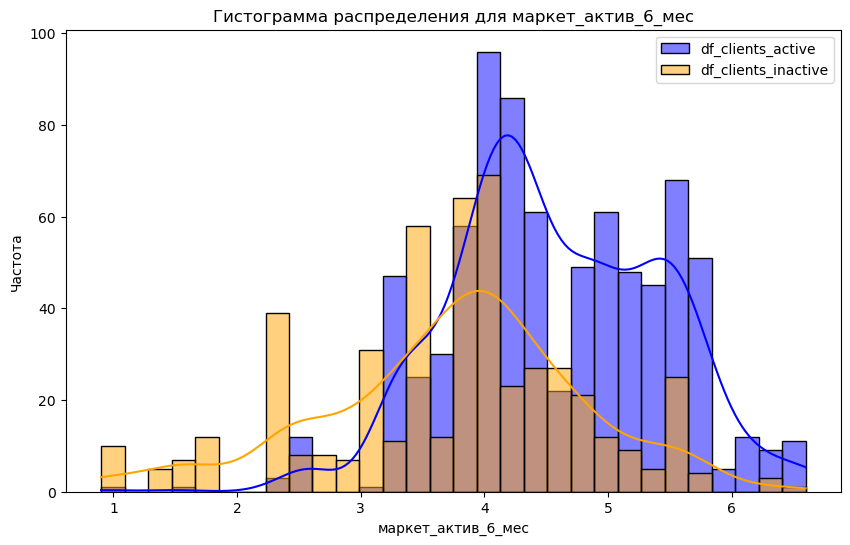

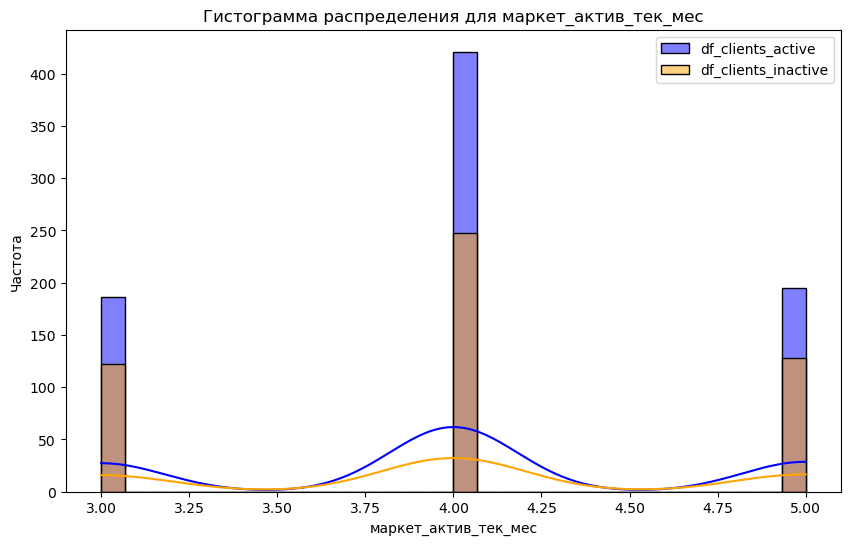

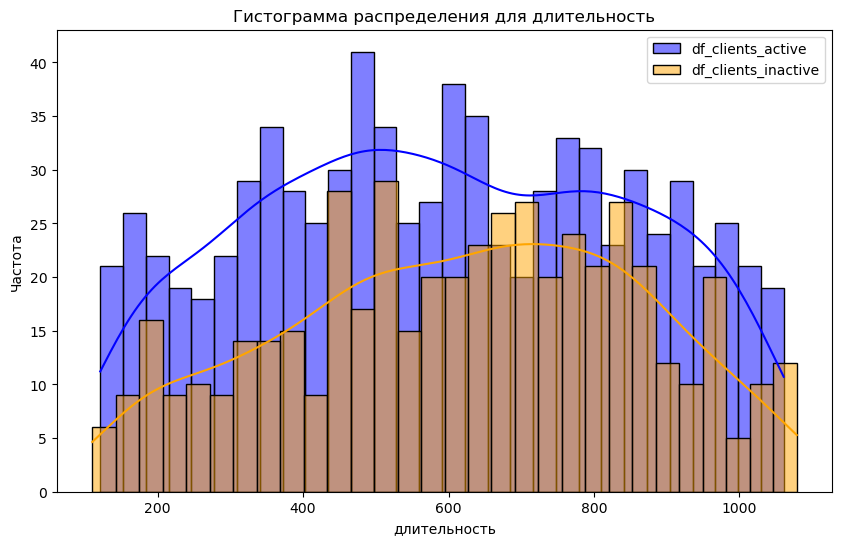

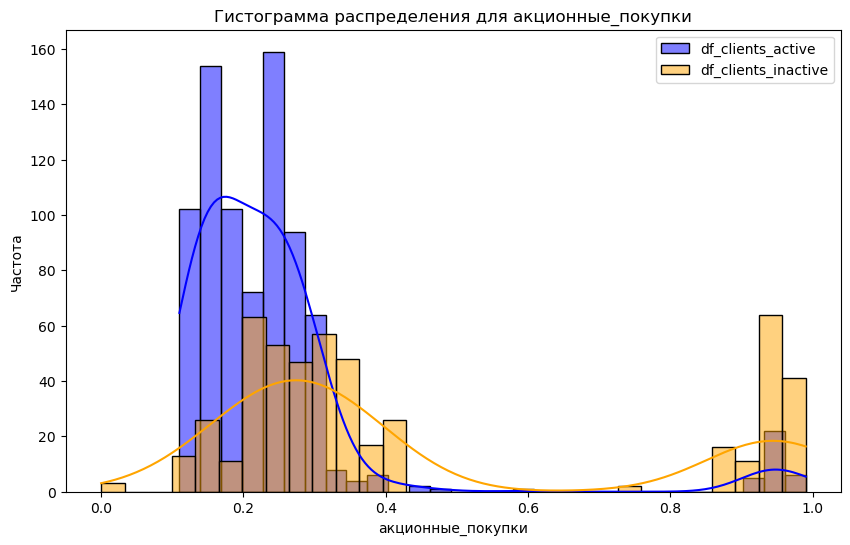

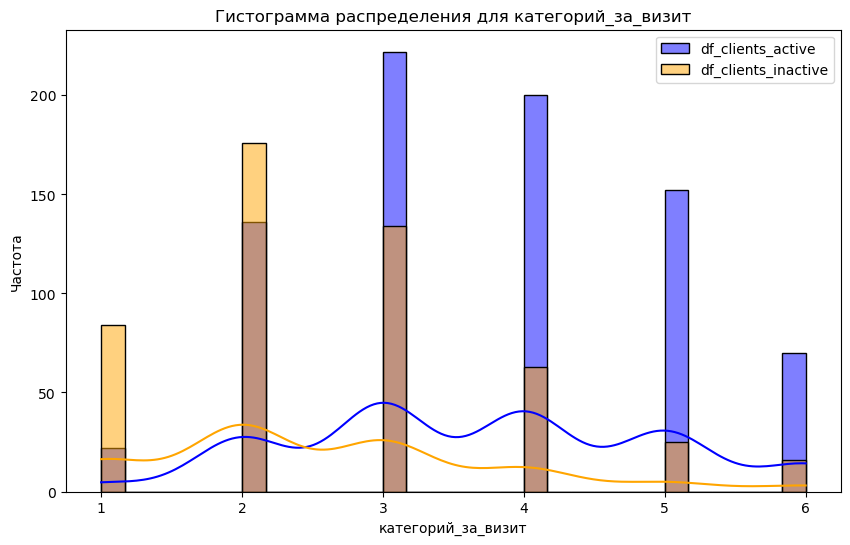

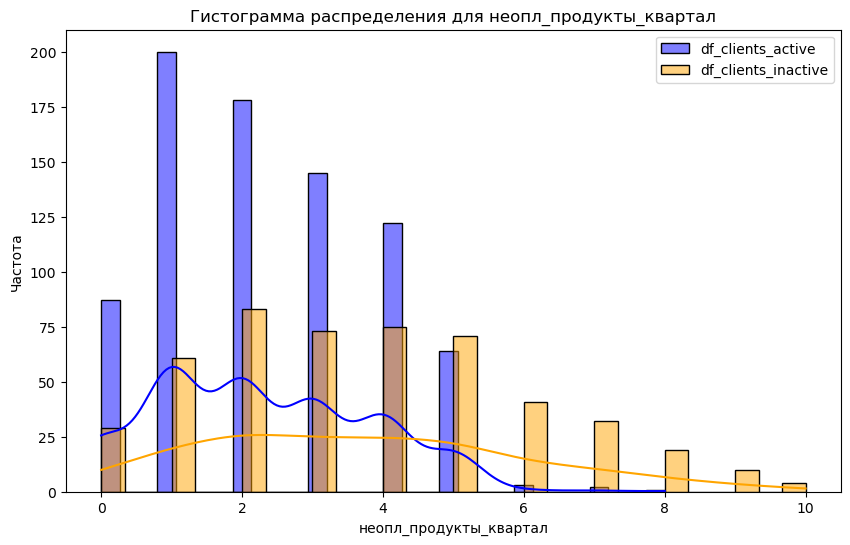

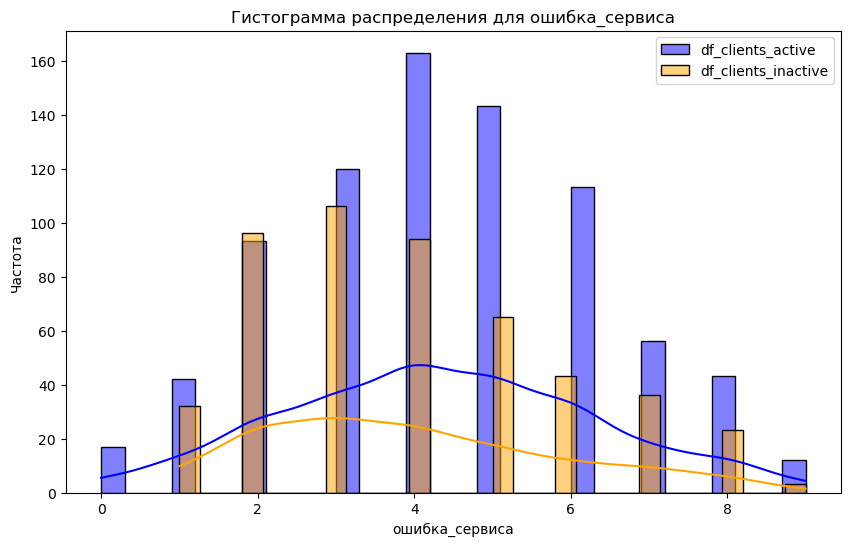

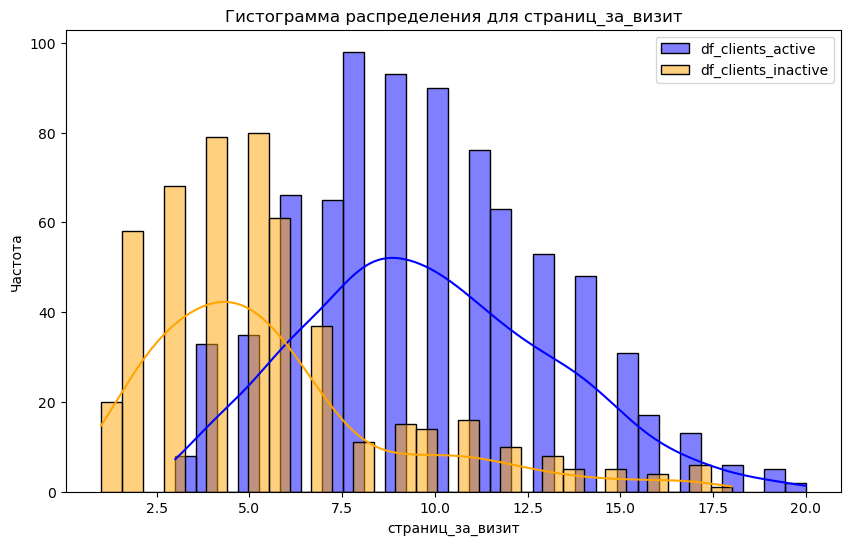

In [47]:
#создадим список количественных признаков и сравним распределения df_filtered и df_full
# создадим функцию для построения гистограмм
def plot_overlay_histograms(df1, df2, numeric_columns):
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))

        # Гистограмма для первого датафрейма
        sns.histplot(df1[column], bins=30, color='blue', alpha=0.5, kde=True, label='df_clients_active')
        
        # Гистограмма для второго датафрейма
        sns.histplot(df2[column], bins=30, color='orange', alpha=0.5, kde=True, label='df_clients_inactive')

        plt.title(f'Гистограмма распределения для {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.legend()
        plt.show()

# Используем числовые столбцы
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки'
                          , 'категорий_за_визит', 'неопл_продукты_квартал', 'ошибка_сервиса', 'страниц_за_визит']
plot_overlay_histograms(df_clients_active, df_clients_inactive, num_columns)

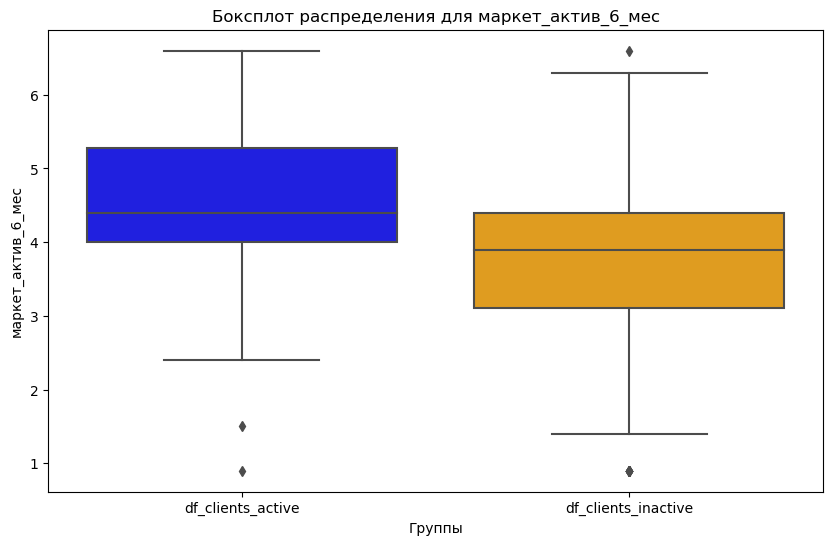

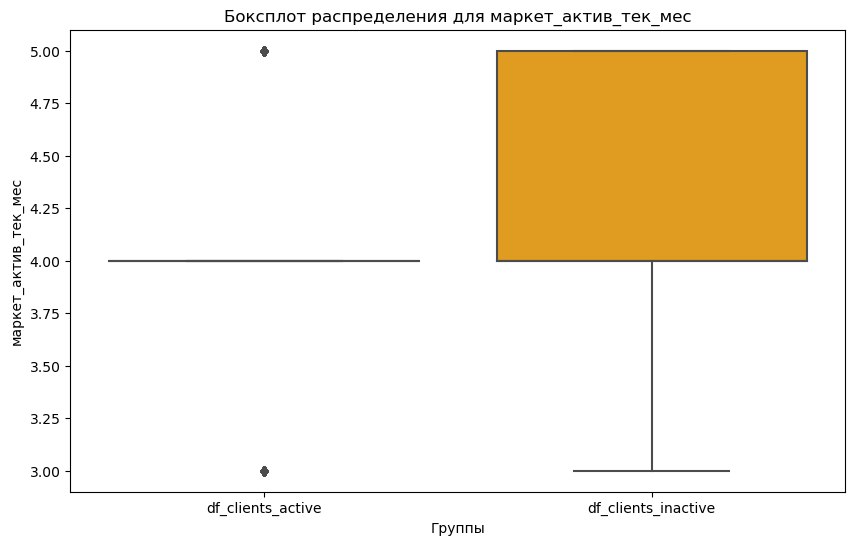

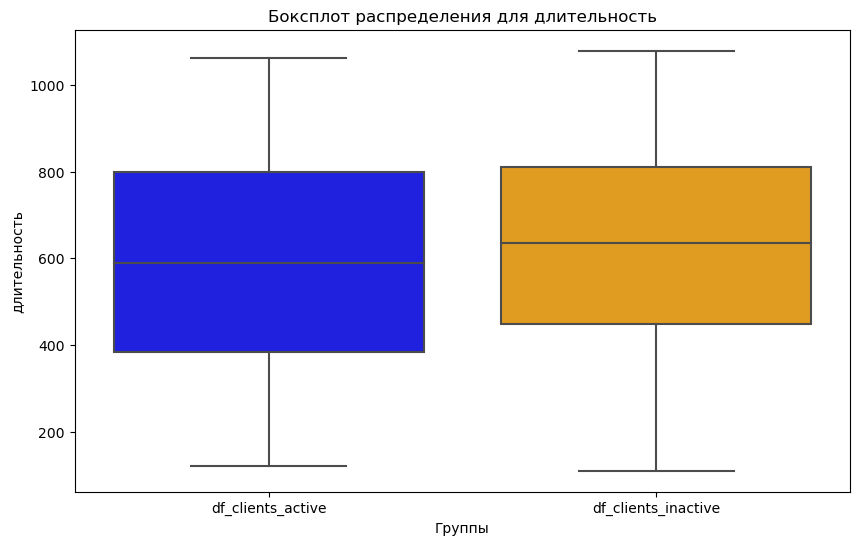

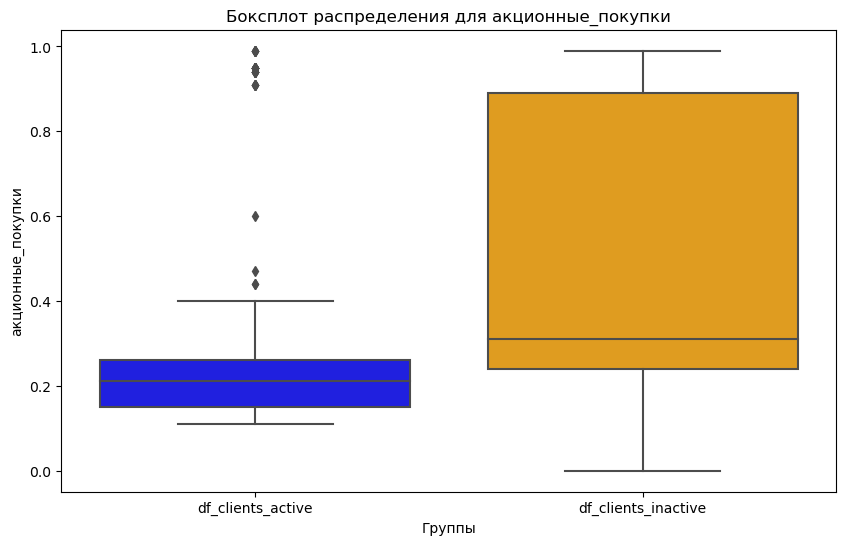

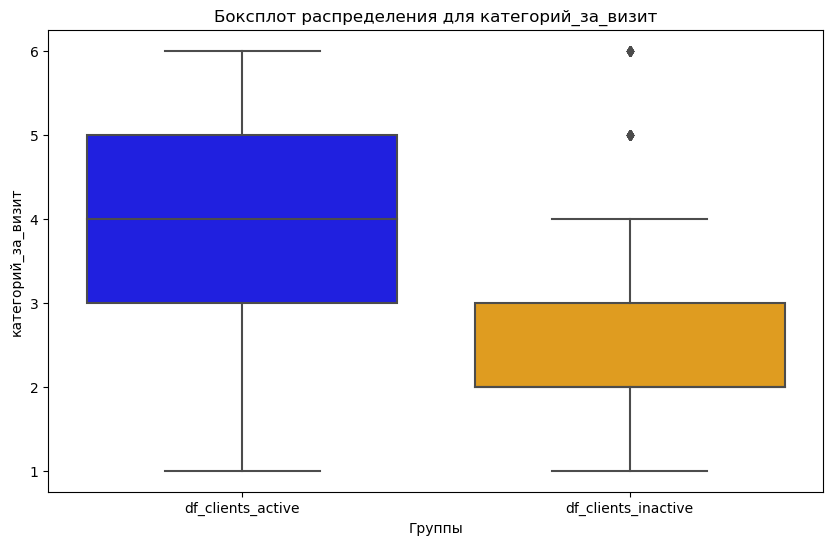

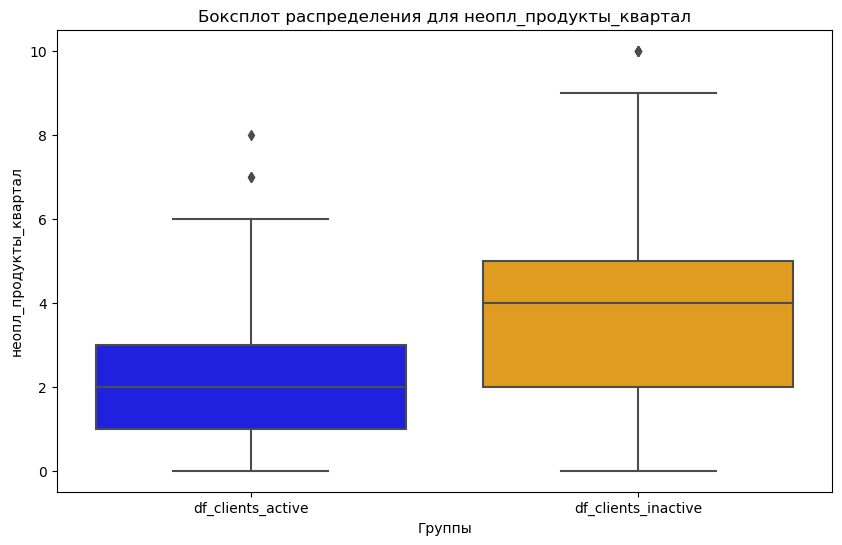

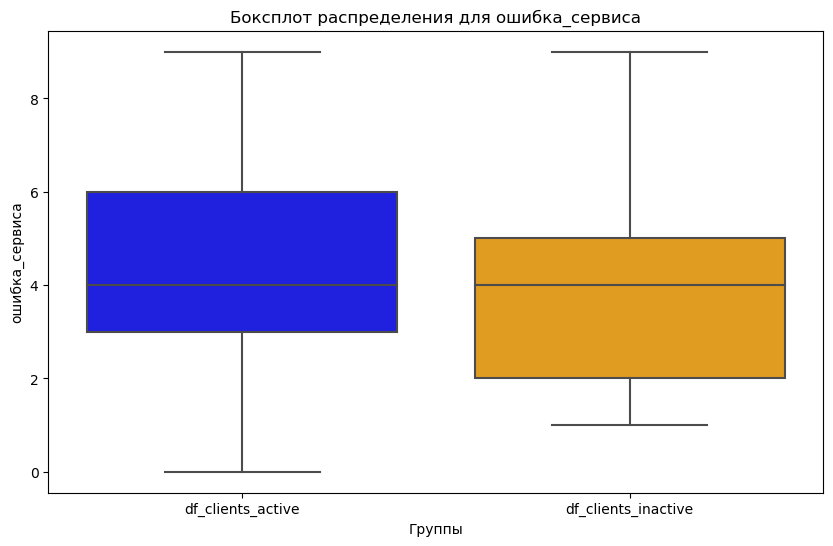

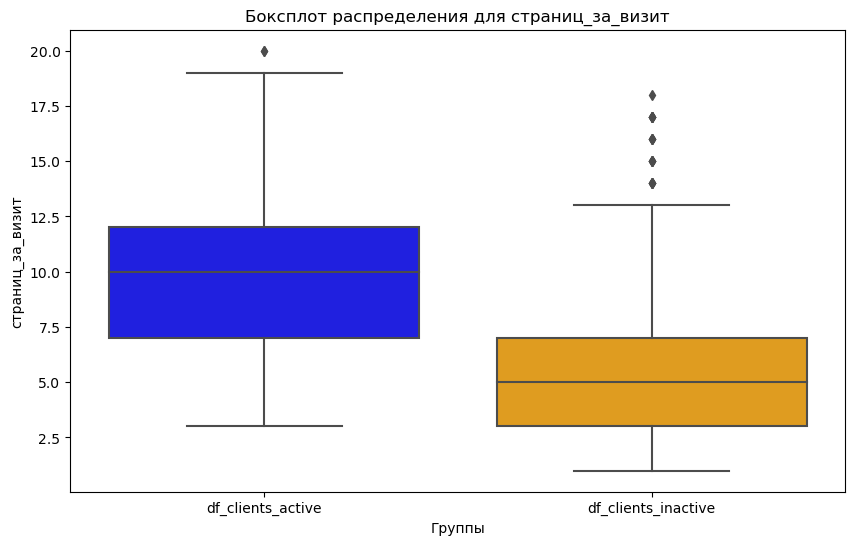

In [48]:
#Напишем функцию для построения боксплотов и сравнения двух датафреймов
def plot_overlay_boxplots(df1, df2, numeric_columns):
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        
        # Объединим оба датафрейма в один, добавив новый столбец для обозначения принадлежности
        df1_copy = df1[[column]].copy()
        df1_copy['group'] = 'df_clients_active'
        
        df2_copy = df2[[column]].copy()
        df2_copy['group'] = 'df_clients_inactive'
        
        combined_df = pd.concat([df1_copy, df2_copy])
        
        # Построим боксплот
        sns.boxplot(x='group', y=column, data=combined_df, palette={'df_clients_active': 'blue', 'df_clients_inactive': 'orange'})
        
        plt.title(f'Боксплот распределения для {column}')
        plt.xlabel('Группы')
        plt.ylabel(column)
        plt.show()
        
# выведем боксплоты для сравнения
plot_overlay_boxplots(df_clients_active, df_clients_inactive, num_columns)

- **маркет_актив_6 _мес** мы видим, что клиенты со сниженной активность получают меньше внимания от маркетинга
- **маркет_актив_тек_мес** о сути имеет категориальное значение с количеством коммуникаций 3, 4, 5 в месяц (т.е. 3 категории), одинаковые для всех клиентов
- **длительность** в днях с момента регистрации имеет более менее равномерное рапределение для активных клиентов и со скосом вправо для неактивных, значит там больше "стареньких" клиентов
- **акционные_покупки** имеет рапределение с двумя пиками. Мы видим, что сниженная активность уклиентов, которые покупают только по акции
- **категорий_за_визит.** Средний просмотр категорий за визит также можно сделать категориальный признаком с 6 категориями, неактивные клиенты просматриваюи меньше категорий
- **неопл_продукты_квартал.** Неоплаченные продукты в квартале имеют скошенное вправо распределение и также может быть категориальным признаком с 11 категориями. Больше 6 неоплаченный продуктов имеют неактивные клиенты
- **ошибка_сервиса.**  Число сбоев, которые коснулись покупателя во время посещения сайта напоминает нормальное распределение. Но также является категориальным признаком с 10 категориями. Неактивные клиенты имеют меньше ошибок, но это логично тк они менее активны.
- **страниц_за_визит.** Среднее количество страниц за визит имеет ассиметричное распределение со скосом вправо. Неактивные клиенты просматривают гораздо меньше страниц

In [49]:
# # построим гистограммы и диаграммы размаха для столбцов с количественными признаками
# plot_histogram_and_boxplot(df_clients, num_columns_df_clients)

In [50]:
# создадим спосок столбцов с категориальными признаками df_clients
cat_columns_df_clients = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

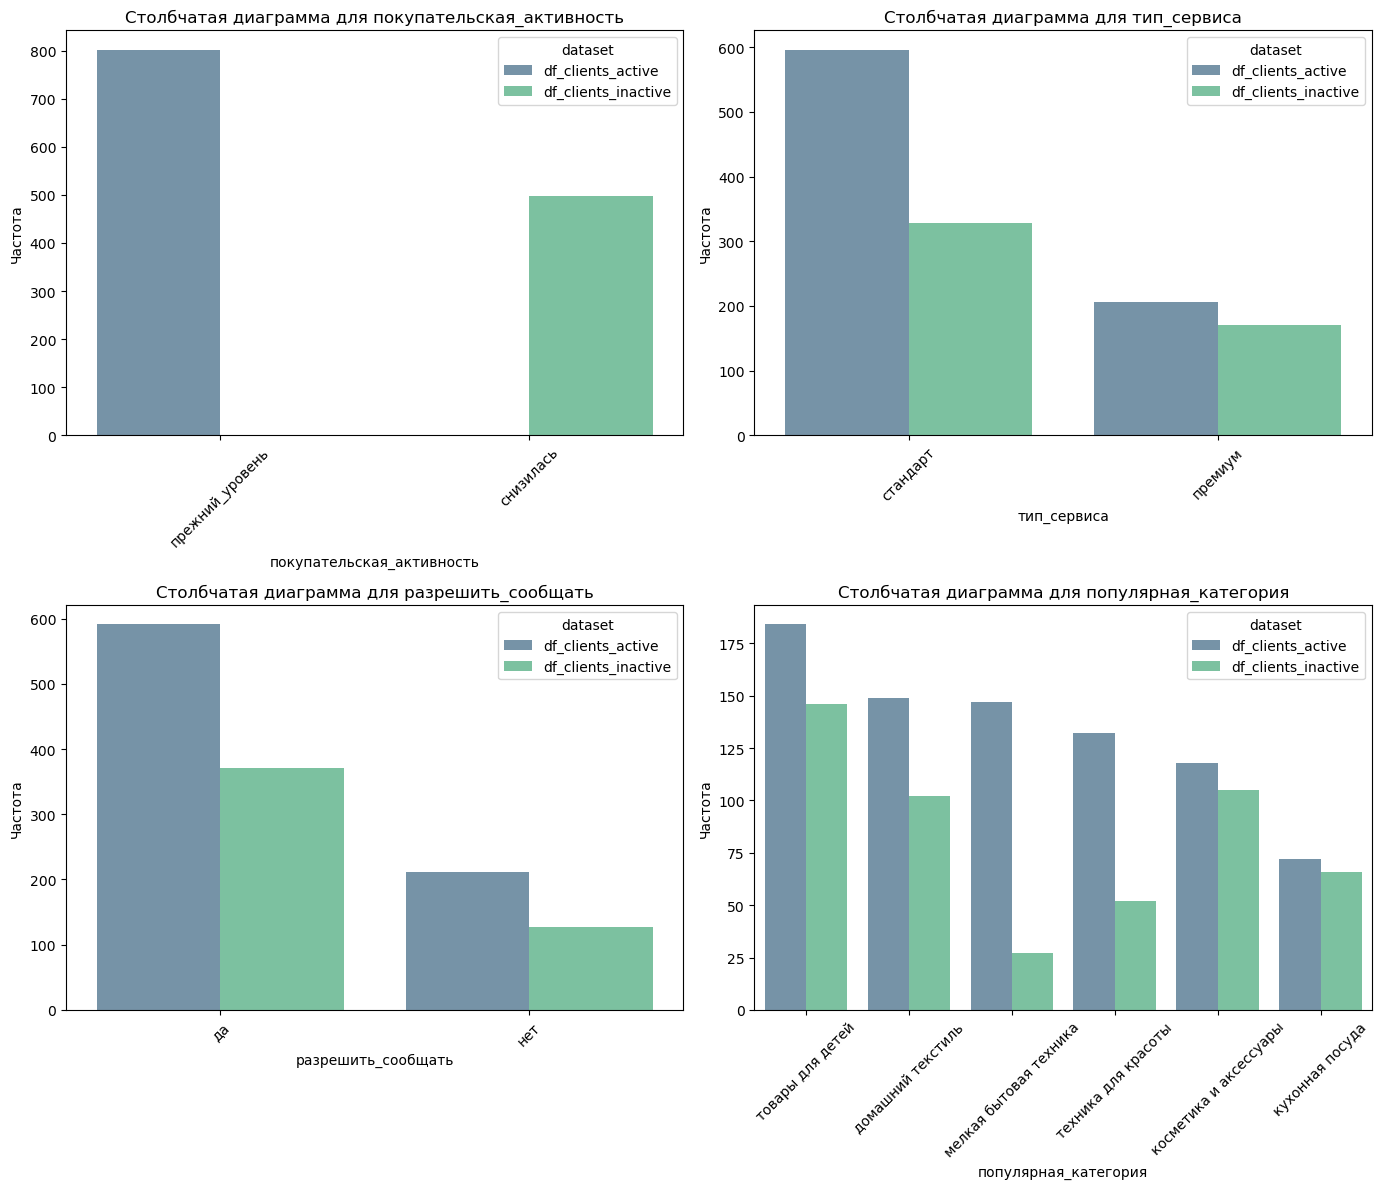

In [51]:
# построим столбчатые диаграммы для столбцов с категориальными признаками

def plot_overlay_bar_charts(df1, df2, categorical_columns):
    num_columns = len(categorical_columns)
    num_rows = (num_columns + 1) // 2  # Вычисление количества строк для подграфиков
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(14, 6 * num_rows))
    axes = axes.flatten()  # Преобразование массива осей в одномерный массив для удобства итерации
    
    for i, column in enumerate(categorical_columns):
        # Объединение данных с добавлением нового столбца для идентификации набора данных
        df1_agg = df1[column].value_counts().reset_index()
        df1_agg.columns = [column, 'count']
        df1_agg['dataset'] = 'df_clients_active'
        
        df2_agg = df2[column].value_counts().reset_index()
        df2_agg.columns = [column, 'count']
        df2_agg['dataset'] = 'df_clients_inactive'
        
        combined_data = pd.concat([df1_agg, df2_agg])
        
        # Построение наложенной столбчатой диаграммы
        sns.barplot(data=combined_data, x=column, y='count', hue='dataset', palette='viridis', ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Столбчатая диаграмма для {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Частота')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    
    # Удаление пустых подграфиков, если количество категориальных столбцов нечетное
    if num_columns % 2 != 0:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    

# построим столбчатые диаграммы для столбцов с категориальными признаками    

plot_overlay_bar_charts(df_clients_active, df_clients_inactive, cat_columns_df_clients)

 Мы видим несбалансированность данных:
 - Покупательская активность снизилась примерно у 500 покупателей, у 800 осталась на прежнем уровне
 - Тип сервиса стандарт более чем в 2 раза превышает премиум
 - Большинство покапателей разрешили им сообщать дополнительную информацию о товаре
 - Самая популярная категория это товары для детей. 

- В данном случае можно выделить, что неактивные пользователи покупают больше всего в категории "товары для детей", на втором месте 'косметика и аксессуары' , что ярче выражено , чем у активных пользователей. Там более равномерно распредеелние по категориям, хотя товары для детей также в лидерах.


In [52]:
# # построим столбчатые диаграммы для столбцов с категориальными признаками
# plot_bar_charts(df_clients, cat_columns_df_clients)

 Мы видим несбалансированность данных:
 - Покупательская активность снизилась примерно у 500 покупателей, у 800 осталась на прежнем уровне
 - Тип сервиса стандарт более чем в 2 раза превышает премиум
 - Большинство покапателей разрешили им сообщать дополнительную информацию о товаре
 - Самая популярная категория это товары для детей. 

#####  Посмотрим признаки df_money

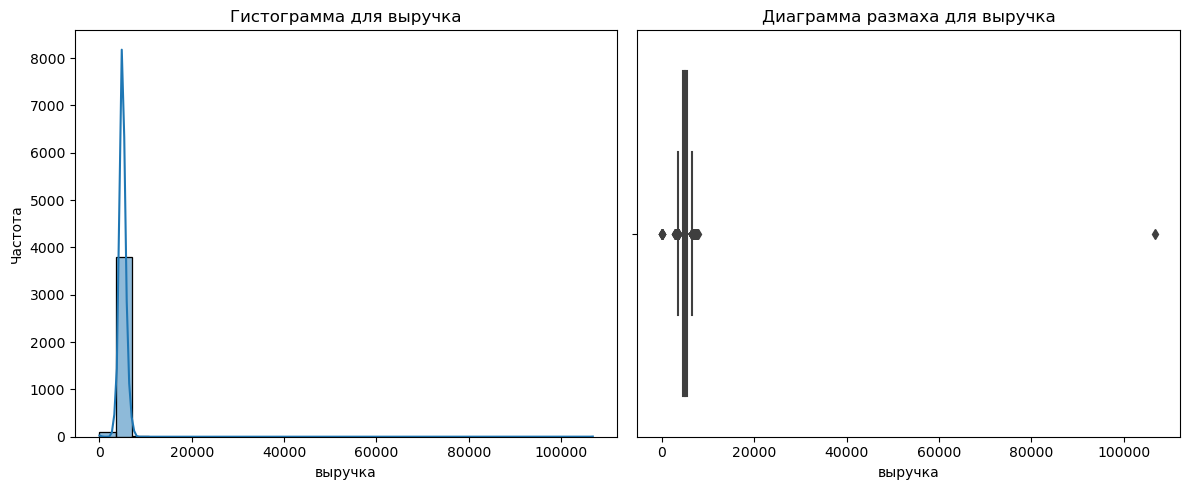

In [53]:
# создадим список столбцов с количественными признаками df_money и применим функцию plot_histogram_and_boxplot
num_columns_df_money = ['выручка']

plot_histogram_and_boxplot(df_money, num_columns_df_money)

In [54]:
# df_money.query('выручка > 10000')&.query('выручка == 0')
df_money[(df_money['выручка'] > 10000) | (df_money['выручка'] == 0)]

id               период   выручка
0   215348  препредыдущий_месяц       0.0
2   215348     предыдущий_месяц       0.0
28  215357  препредыдущий_месяц       0.0
29  215357     предыдущий_месяц       0.0
34  215359     предыдущий_месяц       0.0
35  215359  препредыдущий_месяц       0.0
98  215380        текущий_месяц  106862.2

Мы видим в текущем месяце аномально высокое значение выручки у пользователя с id 215380. Даже если это не ошибка, значение нудно убрать т.к. оно аномальное. Также есть пользователи с 0 выручкой за 3 месяца, их добавим в список для дальнейшего удаления, также добавим аномальное высокого пользователя

In [55]:
# уберем аномально высокую выручку
df_money = df_money[(df_money['выручка'] < 100000)]

#создадим список из пользователей с выручкой 0 
users_to_delete = [215348, 215357, 215359, 215380]

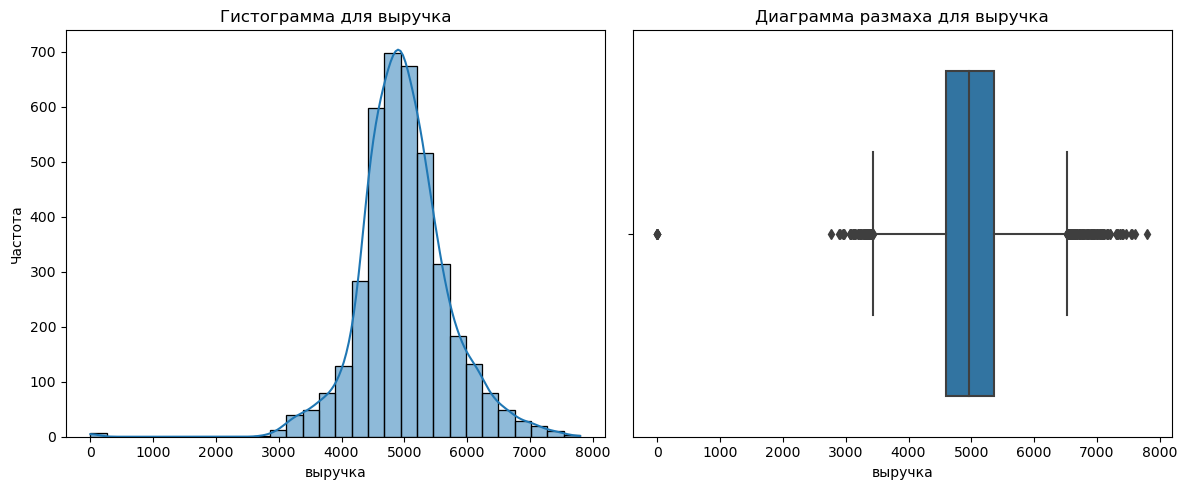

In [56]:
plot_histogram_and_boxplot(df_money, num_columns_df_money)

Выручка распределена нормально. Мы удалили аномальное высокое значение.

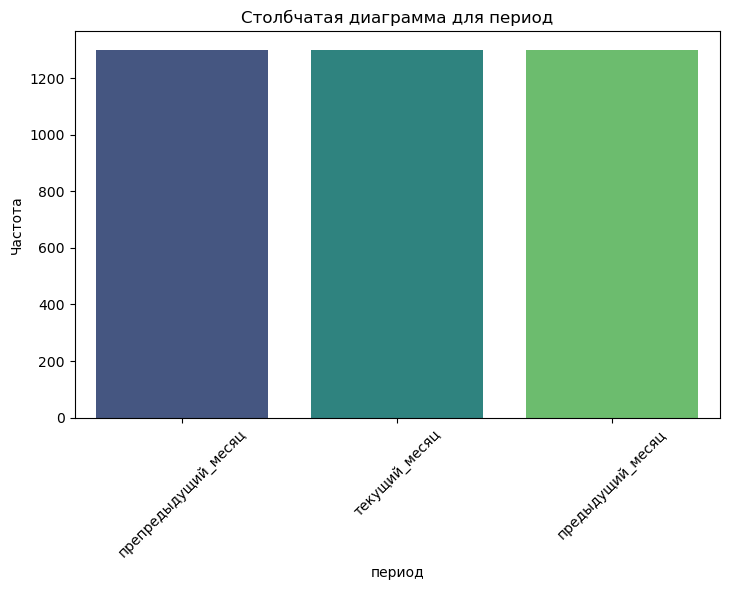

In [57]:
# построим столбчатые диаграммы для столбцов с категориальными признаками df_money
cat_columns_df_money = ['период']
plot_bar_charts(df_money, cat_columns_df_money)

Данные за 3 месяца распределены равномерно

#####  Посмотрим признаки df_time

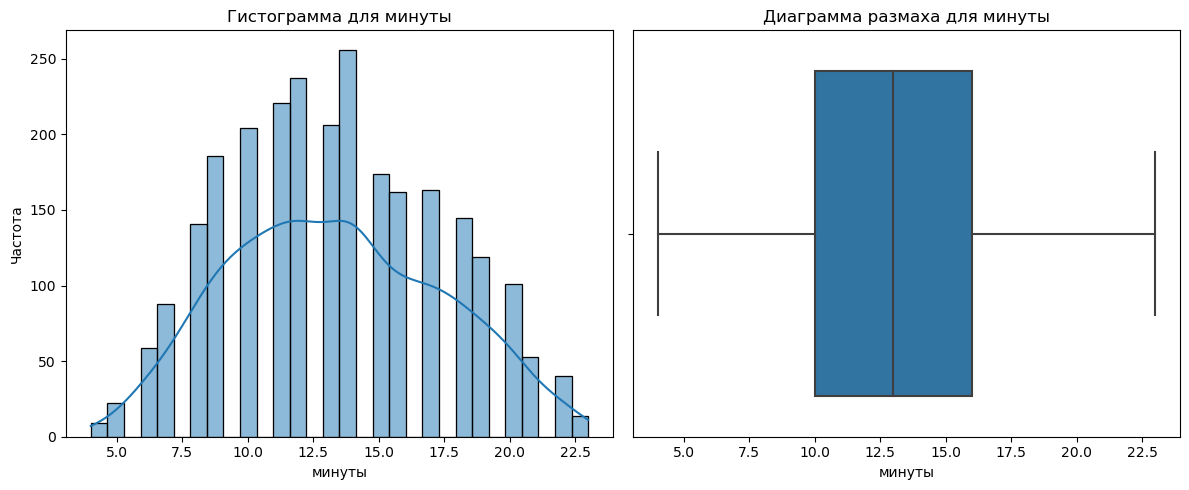

In [58]:
# создадим список столбцов с количественными признаками df_time и применим функцию plot_histogram_and_boxplot
num_columns_df_time = ['минуты']

plot_histogram_and_boxplot(df_time, num_columns_df_time)


Минуты распределены нормально. Медиана на значениии 13

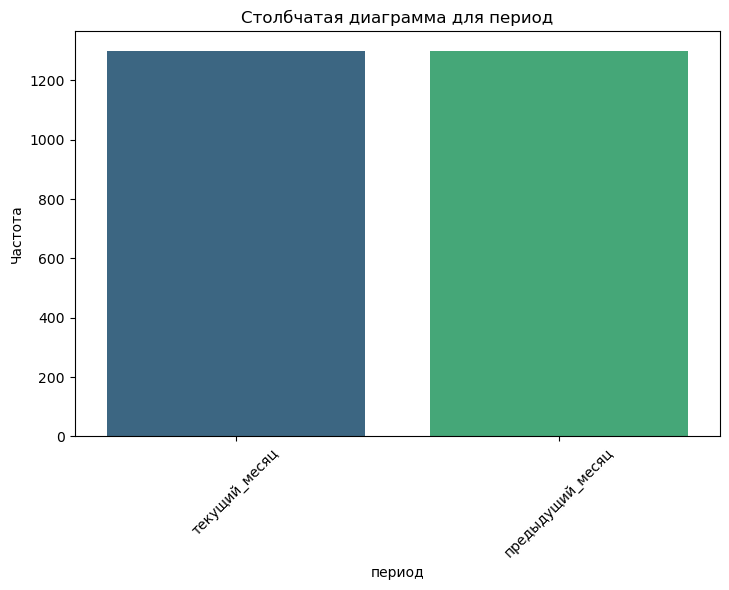

In [59]:
# построим столбчатые диаграммы для столбцов с категориальными признаками df_time
cat_columns_df_time = ['период']
plot_bar_charts(df_time, cat_columns_df_time)

Данные по месяцам распределены равномерно

#####  Посмотрим признаки df_value

In [60]:
df_value.head()

id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

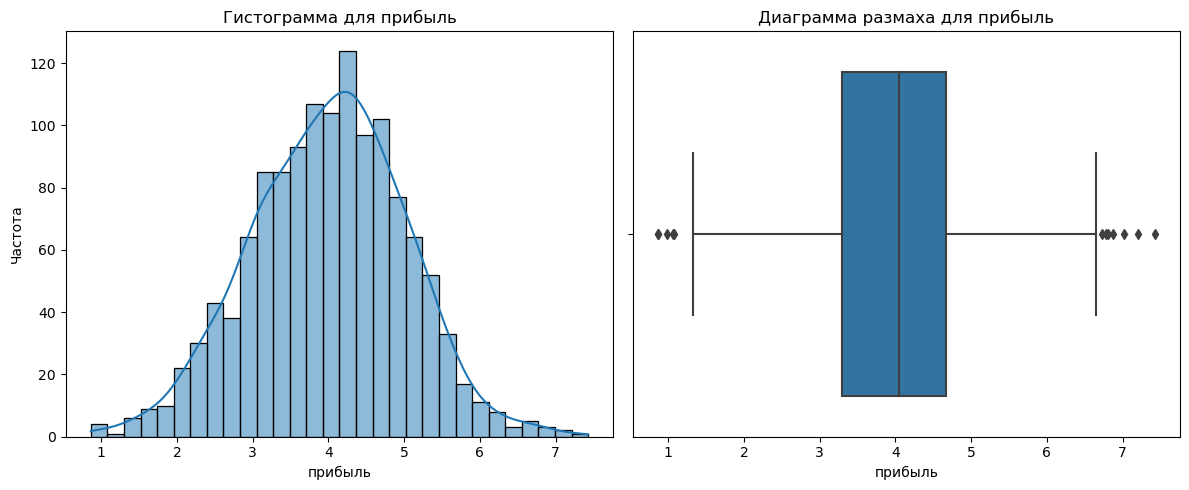

In [61]:
# создадим список столбцов с количественными признаками df_value и применим функцию plot_histogram_and_boxplot
num_columns_df_value = ['прибыль']

plot_histogram_and_boxplot(df_value, num_columns_df_value)

Прибыль распределена нормально, но есть небольшие выбросы

In [62]:
#напишем функцию для удаление пользвотей с нулевой прибылью и применим ее
def remove_users(df, users):
    return df[~df['id'].isin(users)]


df_value = remove_users(df_value, users_to_delete)
df_money = remove_users(df_money, users_to_delete)
df_time = remove_users(df_time, users_to_delete)
df_clients = remove_users(df_clients, users_to_delete)


print('df_value', df_value.shape)
print('df_money', df_money.shape)
print('df_time', df_time.shape)
print('df_clients', df_clients.shape)

df_value (1296, 2)
df_money (3888, 3)
df_time (2592, 3)
df_clients (1296, 13)


Выводы: 
 - **df_clients** Количественные данные в таблице df_clients имеют ассиметричное распределение у многих признаков, также были обнаружены выбросы. Столбцы: 'категорий_за_визит', 'неопл_продукты_квартал', 'ошибка_сервиса' по сути являются категориальные признаками Категориальные признаки несбалансированное распределение :  
 - **df_money** Был обнаружен пользователь с аномально высокой выручкой. Он был удален. Выручка имеет нормально распределение. А данные по месяцам сбалансированы.
 - **df_time** Данные по времени имеют нормальное распределение. А данные по месяцам сбалансированы.
 - **df_value** Данные по прибыли имеют нормальное распределение.
 - Пользователи не принесшие выручку были удалены из всех таблиц, также как и пользователь с аномально высокой выручкой.

####  Этап 4. Объединение таблиц

In [63]:
df_clients.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
1  215349                 снизилась     премиум                 да   
2  215350                 снизилась    стандарт                нет   
3  215351                 снизилась    стандарт                 да   
4  215352                 снизилась    стандарт                нет   
5  215353                 снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   

  популярная_категория  категорий_за_визит  неопл_продукты_квартал  \
1     товары для детей                   4                       4   
2    домашний текстиль                   5                       2   
3     товары для детей                   5                       0   
4     товары для детей                   3                       2   
5    домашний текстиль                   4                       1   

   ошибка_сервиса  страниц_за_визит  
1               2                 5  
2               1                 5  
3               6                 4  
4               3                 2  
5               1                 4

In [64]:
df_money.head()

id               период  выручка
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4

In [65]:
# Поворот таблицы df_money, чтобы создать отдельные столбцы для каждого периода
df_money_pivot = df_money.pivot(index='id', columns='период', values='выручка').reset_index()

# изменим названия столбцов df_money_pivot
df_money_pivot.columns = ['id', 'выручка_препред_месяц', 'выручка_пред_месяц', 'выручка_тек_месяц']

# Поворот таблицы df_time, чтобы создать отдельные столбцы для каждого периода
df_time_pivot = df_time.pivot(index='id', columns='период', values='минуты').reset_index()

#Изменим названия столбцов df_time_pivot
df_time_pivot.columns = ['id', 'минуты_пред_месяц', 'минуты_тек_месяц']


#Объединим таблицы df_clients и df_money_pivot и df_time_pivot
df_new = df_clients.merge(df_money_pivot, on='id', how='left')
df_new = df_new.merge(df_time_pivot, on='id', how='left')
df_new.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 снизилась     премиум                 да   
1  215350                 снизилась    стандарт                нет   
2  215351                 снизилась    стандарт                 да   
3  215352                 снизилась    стандарт                нет   
4  215353                 снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  категорий_за_визит  неопл_продукты_квартал  \
0     товары для детей                   4                       4   
1    домашний текстиль                   5                       2   
2     товары для детей                   5                       0   
3     товары для детей                   3                       2   
4    домашний текстиль                   4                       1   

   ошибка_сервиса  страниц_за_визит  выручка_препред_месяц  \
0               2                 5                 5216.0   
1               1                 5                 5457.5   
2               6                 4                 6158.0   
3               3                 2                 5807.5   
4               1                 4                 4738.5   

   выручка_пред_месяц  выручка_тек_месяц  минуты_пред_месяц  минуты_тек_месяц  
0              4472.0             4971.6                 12                10  
1              4826.0             5058.4                  8                13  
2              4793.0             6610.4                 11                13  
3              4594.0             5872.5                  8                11  
4              5124.0             5388.5                 10                10

In [66]:
df_clients.shape

(1296, 13)

In [67]:
df_new.shape

(1296, 18)

Таблицы объеденены, данные о выручке и времени по месяцам выведены в отдельных столбцам. Можно приступить к корреляционному анализу.

####  Этап 5. Корреляционный анализ данных

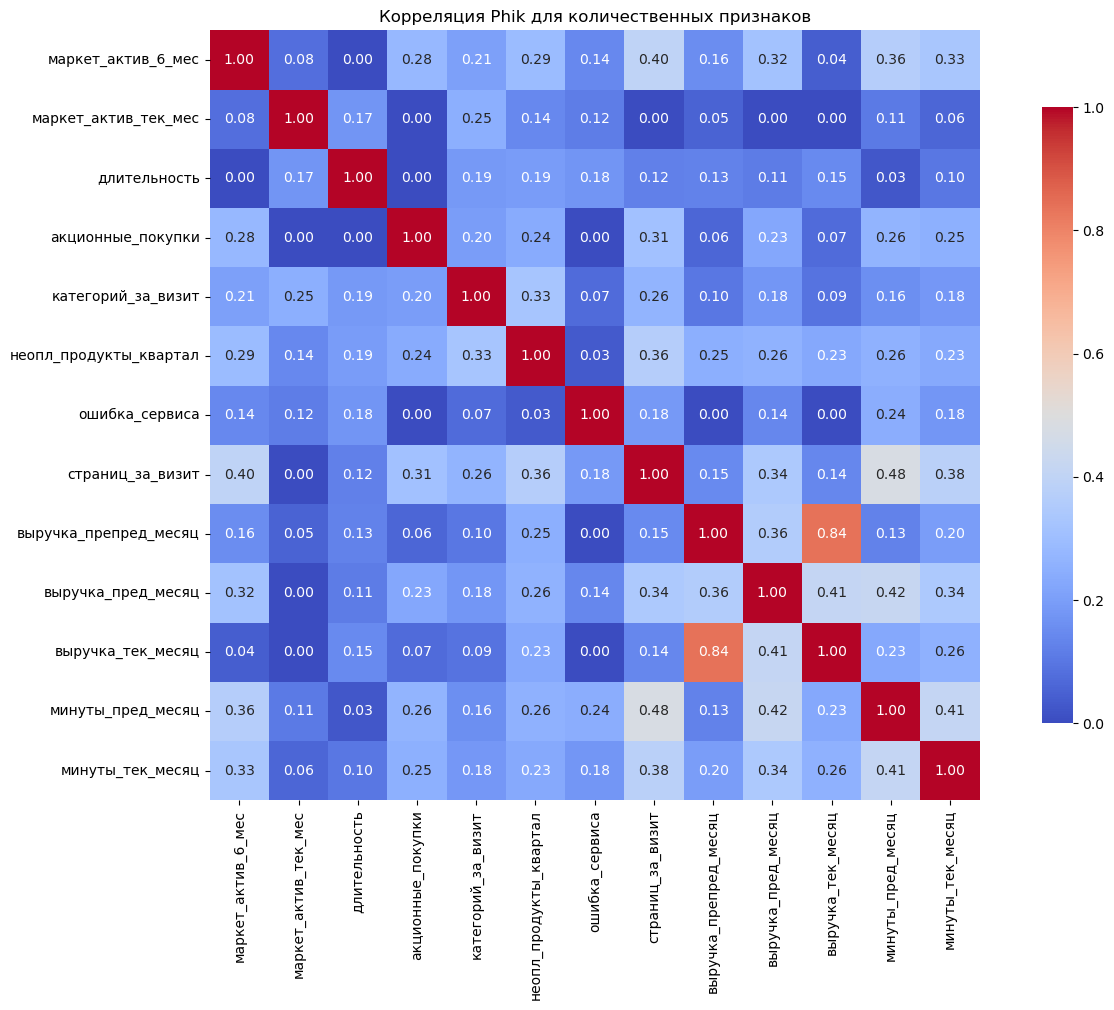

маркет_актив_6_мес  маркет_актив_тек_мес  \
маркет_актив_6_мес                1.000000              0.000000   
маркет_актив_тек_мес              0.000000              1.000000   
длительность                      0.134552              0.000000   
акционные_покупки                 0.759460              0.470770   
категорий_за_визит                0.000000              0.815689   
неопл_продукты_квартал            0.603438              0.584590   
ошибка_сервиса                    0.485507              0.000000   
страниц_за_визит                  0.326803              0.902287   
выручка_препред_месяц             0.336487              0.000000   
выручка_пред_месяц                0.123250              0.743021   
выручка_тек_месяц                 0.000000              0.000000   
минуты_пред_месяц                 0.572069              0.534138   
минуты_тек_месяц                  0.800796              0.321420   

                        длительность  акционные_покупки  категорий_за_визит  \
маркет_актив_6_мес          0.134552           0.759460            0.000000   
маркет_актив_тек_мес        0.000000           0.470770            0.815689   
длительность                1.000000           0.000000            0.000000   
акционные_покупки           0.000000           1.000000            0.678387   
категорий_за_визит          0.000000           0.678387            1.000000   
неопл_продукты_квартал      0.280468           0.687290            0.615076   
ошибка_сервиса              0.000000           0.000000            0.525468   
страниц_за_визит            0.000000           0.863145            0.866262   
выручка_препред_месяц       0.000000           0.000000            0.000000   
выручка_пред_месяц          0.000000           0.000000            0.000000   
выручка_тек_месяц           0.000000           0.000000            0.000000   
минуты_пред_месяц           0.611114           0.363532            0.407048   
минуты_тек_месяц            0.411945           0.000000            0.102009   

                        неопл_продукты_квартал  ошибка_сервиса  \
маркет_актив_6_мес                    0.603438        0.485507   
маркет_актив_тек_мес                  0.584590        0.000000   
длительность                          0.280468        0.000000   
акционные_покупки                     0.687290        0.000000   
категорий_за_визит                    0.615076        0.525468   
неопл_продукты_квартал                1.000000        0.515232   
ошибка_сервиса                        0.515232        1.000000   
страниц_за_визит                      0.463967        0.591745   
выручка_препред_месяц                 0.000000        0.000000   
выручка_пред_месяц                    0.253147        0.275198   
выручка_тек_месяц                     0.000000        0.000000   
минуты_пред_месяц                     0.377833        0.851308   
минуты_тек_месяц                      0.787898        0.393451   

                        страниц_за_визит  выручка_препред_месяц  \
маркет_актив_6_мес              0.326803               0.336487   
маркет_актив_тек_мес            0.902287               0.000000   
длительность                    0.000000               0.000000   
акционные_покупки               0.863145               0.000000   
категорий_за_визит              0.866262               0.000000   
неопл_продукты_квартал          0.463967               0.000000   
ошибка_сервиса                  0.591745               0.000000   
страниц_за_визит                1.000000               0.000000   
выручка_препред_месяц           0.000000               1.000000   
выручка_пред_месяц              0.787102               0.842273   
выручка_тек_месяц               0.000000               0.980450   
минуты_пред_месяц               0.871219               0.000000   
минуты_тек_месяц                0.510097               0.000000   

                        выручка_пред_месяц  выручка_тек_месяц  \
маркет_актив_6_мес                0

In [68]:
# Фильтруем только количественные признаки
numerical_df = df_new.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns=['id'])

# Задаем список количественных признаков
interval_cols = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
                 'категорий_за_визит', 'неопл_продукты_квартал', 'ошибка_сервиса', 'страниц_за_визит',
                 'выручка_препред_месяц', 'выручка_пред_месяц', 'выручка_тек_месяц', 'минуты_пред_месяц',
                 'минуты_тек_месяц']


# Вычисляем корреляцию phik
phik_corr = numerical_df.phik_matrix(interval_cols = interval_cols)


# Отображаем с помощью sns.heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляция Phik для количественных признаков')
plt.show()

phik_corr.phik_matrix(interval_cols = interval_cols)

Видно высокую корреляцию 0.84 между выручкой за тек месяц и за препредыдущий, но значение меньше 0.9, поэтому нельзя назвать мультиколлинеарными признаками, оставим как есть.

####  Этап 6. Пайплайны и выбор моделей

#####  Подготовка данный  и настройка Пайплайна

In [69]:
df_new.set_index('id', inplace=True)
df_new.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 снизилась     премиум                 да   
215350                 снизилась    стандарт                нет   
215351                 снизилась    стандарт                 да   
215352                 снизилась    стандарт                нет   
215353                 снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

        акционные_покупки популярная_категория  категорий_за_визит  \
id                                                                   
215349               0.75     товары для детей                   4   
215350               0.14    домашний текстиль                   5   
215351               0.99     товары для детей                   5   
215352               0.94     товары для детей                   3   
215353               0.26    домашний текстиль                   4   

        неопл_продукты_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                 
215349                       4               2                 5   
215350                       2               1                 5   
215351                       0               6                 4   
215352                       2               3                 2   
215353                       1               1                 4   

        выручка_препред_месяц  выручка_пред_месяц  выручка_тек_месяц  \
id                                                                     
215349                 5216.0              4472.0             4971.6   
215350                 5457.5              4826.0             5058.4   
215351                 6158.0              4793.0             6610.4   
215352                 5807.5              4594.0             5872.5   
215353                 4738.5              5124.0             5388.5   

        минуты_пред_месяц  минуты_тек_месяц  
id                                           
215349                 12                10  
215350                  8                13  
215351                 11                13  
215352                  8                11  
215353                 10                10

In [70]:
# Разбиваем df_new на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    df_new.drop(['покупательская_активность'], axis=1),
    df_new['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_new['покупательская_активность']
)

X_train.head()

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
215858    стандарт                 да                 5.5   
215361    стандарт                 да                 5.1   
215884    стандарт                 да                 4.3   
216564    стандарт                 да                 5.6   
215715     премиум                 да                 3.6   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
215858                     4           510               0.15   
215361                     4           199               0.23   
215884                     5           997               0.17   
216564                     4           342               0.94   
215715                     5           873               0.39   

          популярная_категория  категорий_за_визит  неопл_продукты_квартал  \
id                                                                           
215858  мелкая бытовая техника                   2                       4   
215361     техника для красоты                   4                       5   
215884  мелкая бытовая техника                   5                       1   
216564         кухонная посуда                   2                       7   
215715        товары для детей                   3                       2   

        ошибка_сервиса  страниц_за_визит  выручка_препред_месяц  \
id                                                                
215858               7                16                 5170.5   
215361               2                 3                 6400.0   
215884               3                11                 4113.0   
216564               5                 8                 4930.0   
215715               2                 5                 3716.0   

        выручка_пред_месяц  выручка_тек_месяц  минуты_пред_месяц  \
id                                                                 
215858              4347.0             6014.2                 20   
215361              4597.0             3789.7                 11   
215884              4626.0             3798.4                 13   
216564              5269.0             4766.2                 14   
215715              4691.0             4600.0                 10   

        минуты_тек_месяц  
id                        
215858                 6  
215361                13  
215884                10  
216564                19  
215715                10

In [71]:
#Закодируем целевой признак с помощью LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [72]:
#Создадим список с количественными признаками
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
                 'категорий_за_визит', 'неопл_продукты_квартал', 'ошибка_сервиса', 'страниц_за_визит',
                 'выручка_препред_месяц', 'выручка_пред_месяц', 'выручка_тек_месяц', 'минуты_пред_месяц',
                 'минуты_тек_месяц']
            
#Создадим список с категориальными признаками
ohe_columns = ['тип_сервиса', 'разрешить_сообщать','популярная_категория', ]

In [73]:
# создаём пайплайн для подготовки категориальных признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error')
        )
    ]
)


In [74]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [75]:
# создаем итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = {
    'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler(), 
        'passthrough'
    ],
    # укажем модели
     'models' : [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE),
        LogisticRegression(random_state=RANDOM_STATE)
    ]
    
}



#####  Обучение 4-х моделей и выбор лучшей модели

In [76]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [77]:
#поиск оптимальной модели с перебором гиперпараметров
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
)

#обучение модели на тренировочной выборке
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['тип_сервиса',
                                                                          'разрешить_сообщать',
                                                                          'популярная_категория']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['маркет_актив_6_мес',
                                                                          'марке...
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(kernel='poly', random_state=42)],
                          'models__degree': range(2, 3),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [78]:
print('Метрика ROC-AUC для лучшей модели:\n', round(grid.best_score_, 4)) 
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Метрика ROC-AUC для лучшей модели:
 0.8984
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['маркет_актив_6_мес',
                                           

Лучшая модель LogisticRegression с метрикой ROC-AUC = 0.8984

In [79]:
y_pred = grid.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred[:, 1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.9182


**Выводы:** 

Мы создали пайплайн с перебором гиперпараметров и обучили 4 модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC()

Лучшей моделью стала LogisticRegression с параметрами (C=1, penalty='l1', random_state=42, solver='liblinear'). Результат метрики ROC-AUC на тренировочной выборке: 0.8984, а  на тестовой выборке: 0.9182. 

Была выбрана метрика ROC-AUC, потому что она является универсанльой метрикой, отображающей площадь под ROC-кривой. ROC-кривая позволяет легко анализировать компромисс между истинными положительными (TPR) и ложными положительными (FPR) значениями. Это помогает не только в оценке модели, но и в сравнении нескольких моделей друг с другом. Также ROC-AUC устойчива к несбалансированный данным, в отличие от той же Accuracy. А у нас как раз такие данные, как вы узнали во время анализа данных.

####  Этап 7. SHAP и анализ важности признаков

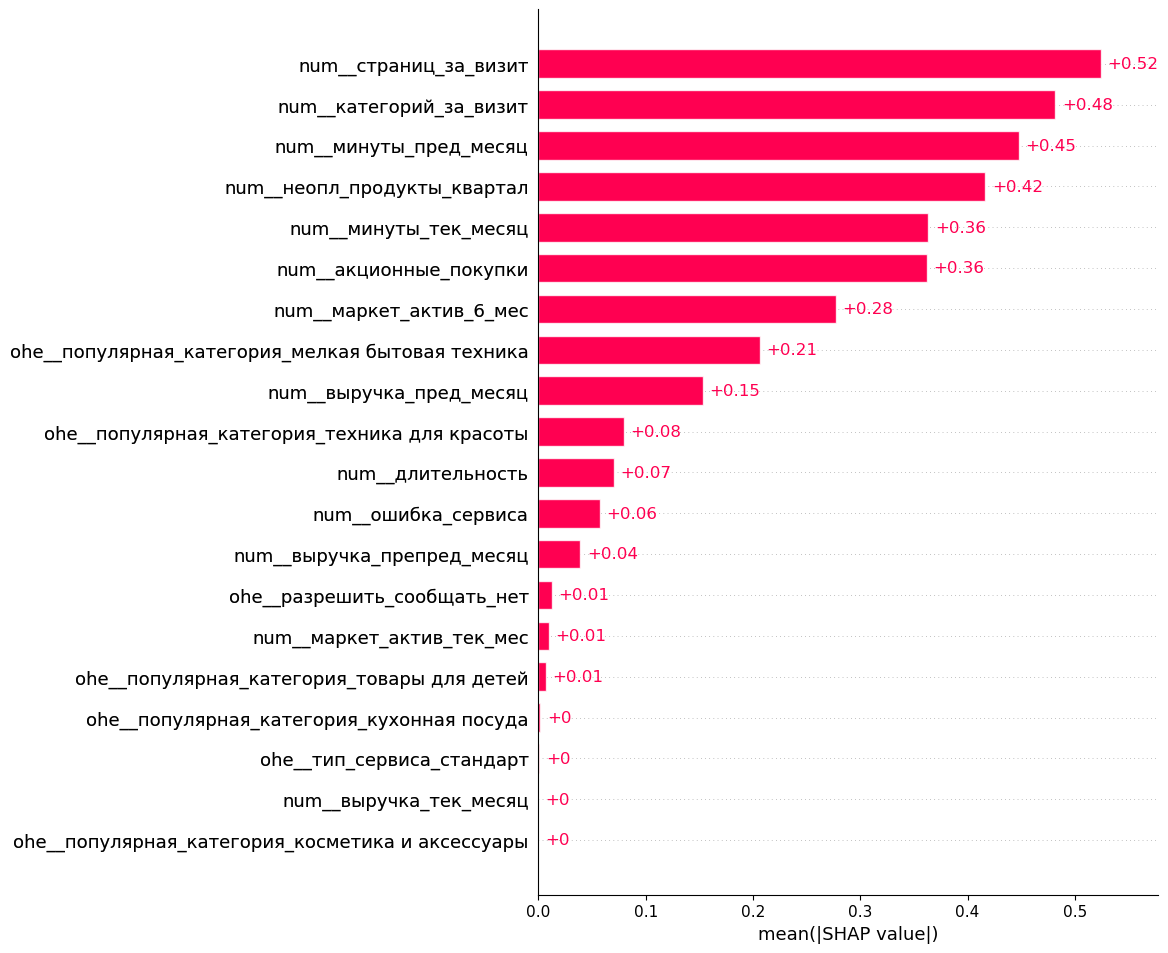

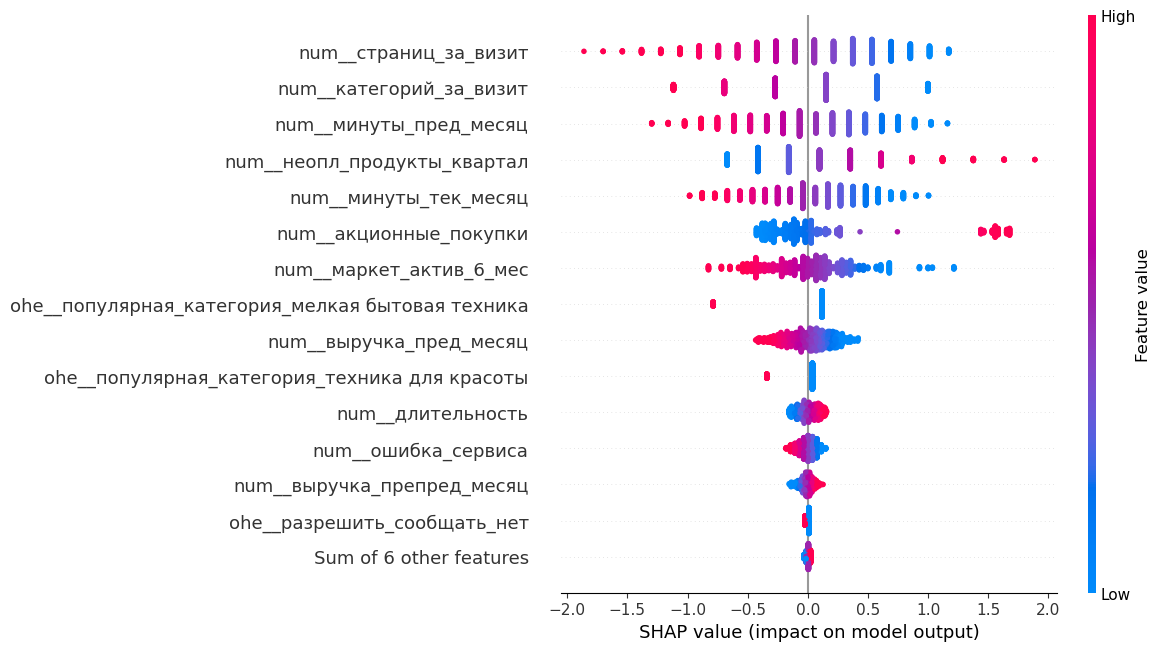

In [80]:
#Найдем важные признаки с помощью метода SHAP

X_1 = grid.best_estimator_['preprocessor'].fit_transform(X_train)

explainer = shap.LinearExplainer(grid.best_estimator_['models'], X_1)

# Получение имен признаков из обученного предварительного процессора
feature_names = grid.best_estimator_['preprocessor'].get_feature_names_out()

# Преобразование тренировочного набора в DataFrame для анализа SHAP
X_1_df = pd.DataFrame(X_1, columns=feature_names)

# Вычисление значений SHAP для тренировочного набора
shap_values = explainer(X_1_df)

# Отображение результатов с использованием визуализаций SHAP
shap.plots.bar(shap_values, max_display=30)
shap.plots.beeswarm(shap_values, max_display=15)

**Выводы:** 
 - Сильно влияют на целевой признак следющие признаки: кол-во страниц за визит, кол-во категорий за визит, минут предыдущий месяц, неоплаченные продукты текущий месяц, минут текущий месяц. Выглядит логично. Активные пользователи смотрят больше страниц и категорий тк выбирают нужные товары, а еще добавляют в корзину в процессе выбора, но не все оплачивают.
 - Слабо влияют на целевой признак следующие признаки: разрешить сообшать_нет, ошибка сервиса, популярная категория: товары для детей, кухонная посуда, косметика и аксессуары, тип сервиса_стандарт.

####  Этап 8. Сегментация покупателей

#####  Используем результаты моделирования и данные о прибыльности покупателей 

In [81]:
X_test.head()

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
216161    стандарт                 да                 4.1   
215654     премиум                нет                 1.4   
216307     премиум                 да                 3.3   
215501     премиум                 да                 3.5   
215934    стандарт                нет                 5.5   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
216161                     4           606               0.15   
215654                     4           684               0.94   
216307                     4           488               0.13   
215501                     3          1057               0.35   
215934                     4           147               0.99   

          популярная_категория  категорий_за_визит  неопл_продукты_квартал  \
id                                                                           
216161     техника для красоты                   6                       1   
215654        товары для детей                   3                       6   
216307       домашний текстиль                   4                       2   
215501       домашний текстиль                   4                       3   
215934  мелкая бытовая техника                   1                       2   

        ошибка_сервиса  страниц_за_визит  выручка_препред_месяц  \
id                                                                
216161               4                12                 3973.0   
215654               1                 6                 3548.0   
216307               8                10                 5444.0   
215501               5                 6                 6604.0   
215934               3                 7                 5090.0   

        выручка_пред_месяц  выручка_тек_месяц  минуты_пред_месяц  \
id                                                                 
216161              4912.0             3289.2                 16   
215654              4656.0             4170.7                 11   
216307              4565.0             6335.8                 20   
215501              4993.0             6758.7                  9   
215934              4451.0             5773.8                 15   

        минуты_тек_месяц  
id                        
216161                17  
215654                 9  
216307                11  
215501                 9  
215934                18

In [82]:
df_value.set_index('id', inplace=True)
df_value.head()

прибыль
id             
215349     4.16
215350     3.13
215351     4.87
215352     4.21
215353     3.95

In [83]:
#Добавим столбец с предсказаниями снижения активности
X_test['Вероятность_снижения_активности'] = y_pred[:, 1]

y_train_pred = grid.predict_proba(X_train)
X_train['Вероятность_снижения_активности'] = y_train_pred[:, 1]

#Объединим X_test и X_train 
df_full = pd.concat([X_train, X_test])

#Добавим столбец с прибылью из df_value
df_full = df_full.merge(df_value, on='id', how='left')
df_full.head()

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
215858    стандарт                 да                 5.5   
215361    стандарт                 да                 5.1   
215884    стандарт                 да                 4.3   
216564    стандарт                 да                 5.6   
215715     премиум                 да                 3.6   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
215858                     4           510               0.15   
215361                     4           199               0.23   
215884                     5           997               0.17   
216564                     4           342               0.94   
215715                     5           873               0.39   

          популярная_категория  категорий_за_визит  неопл_продукты_квартал  \
id                                                                           
215858  мелкая бытовая техника                   2                       4   
215361     техника для красоты                   4                       5   
215884  мелкая бытовая техника                   5                       1   
216564         кухонная посуда                   2                       7   
215715        товары для детей                   3                       2   

        ошибка_сервиса  страниц_за_визит  выручка_препред_месяц  \
id                                                                
215858               7                16                 5170.5   
215361               2                 3                 6400.0   
215884               3                11                 4113.0   
216564               5                 8                 4930.0   
215715               2                 5                 3716.0   

        выручка_пред_месяц  выручка_тек_месяц  минуты_пред_месяц  \
id                                                                 
215858              4347.0             6014.2                 20   
215361              4597.0             3789.7                 11   
215884              4626.0             3798.4                 13   
216564              5269.0             4766.2                 14   
215715              4691.0             4600.0                 10   

        минуты_тек_месяц  Вероятность_снижения_активности  прибыль  
id                                                                  
215858                 6                         0.067245     4.37  
215361                13                         0.560548     4.03  
215884                10                         0.059740     4.37  
216564                19                         0.754338     5.58  
215715                10                         0.786879     4.87

Посмотрим на различные зависимости с прибылью и вероятностью снижения активности

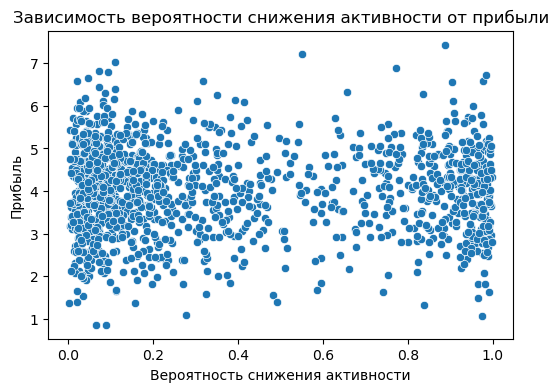

In [84]:
fig = plt.figure(figsize=(6,4))
sns.scatterplot(data=df_full, y='прибыль', x='Вероятность_снижения_активности')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от прибыли')
plt.show()

Зависимости не видно

#####  Изучение данных и их зависимостей

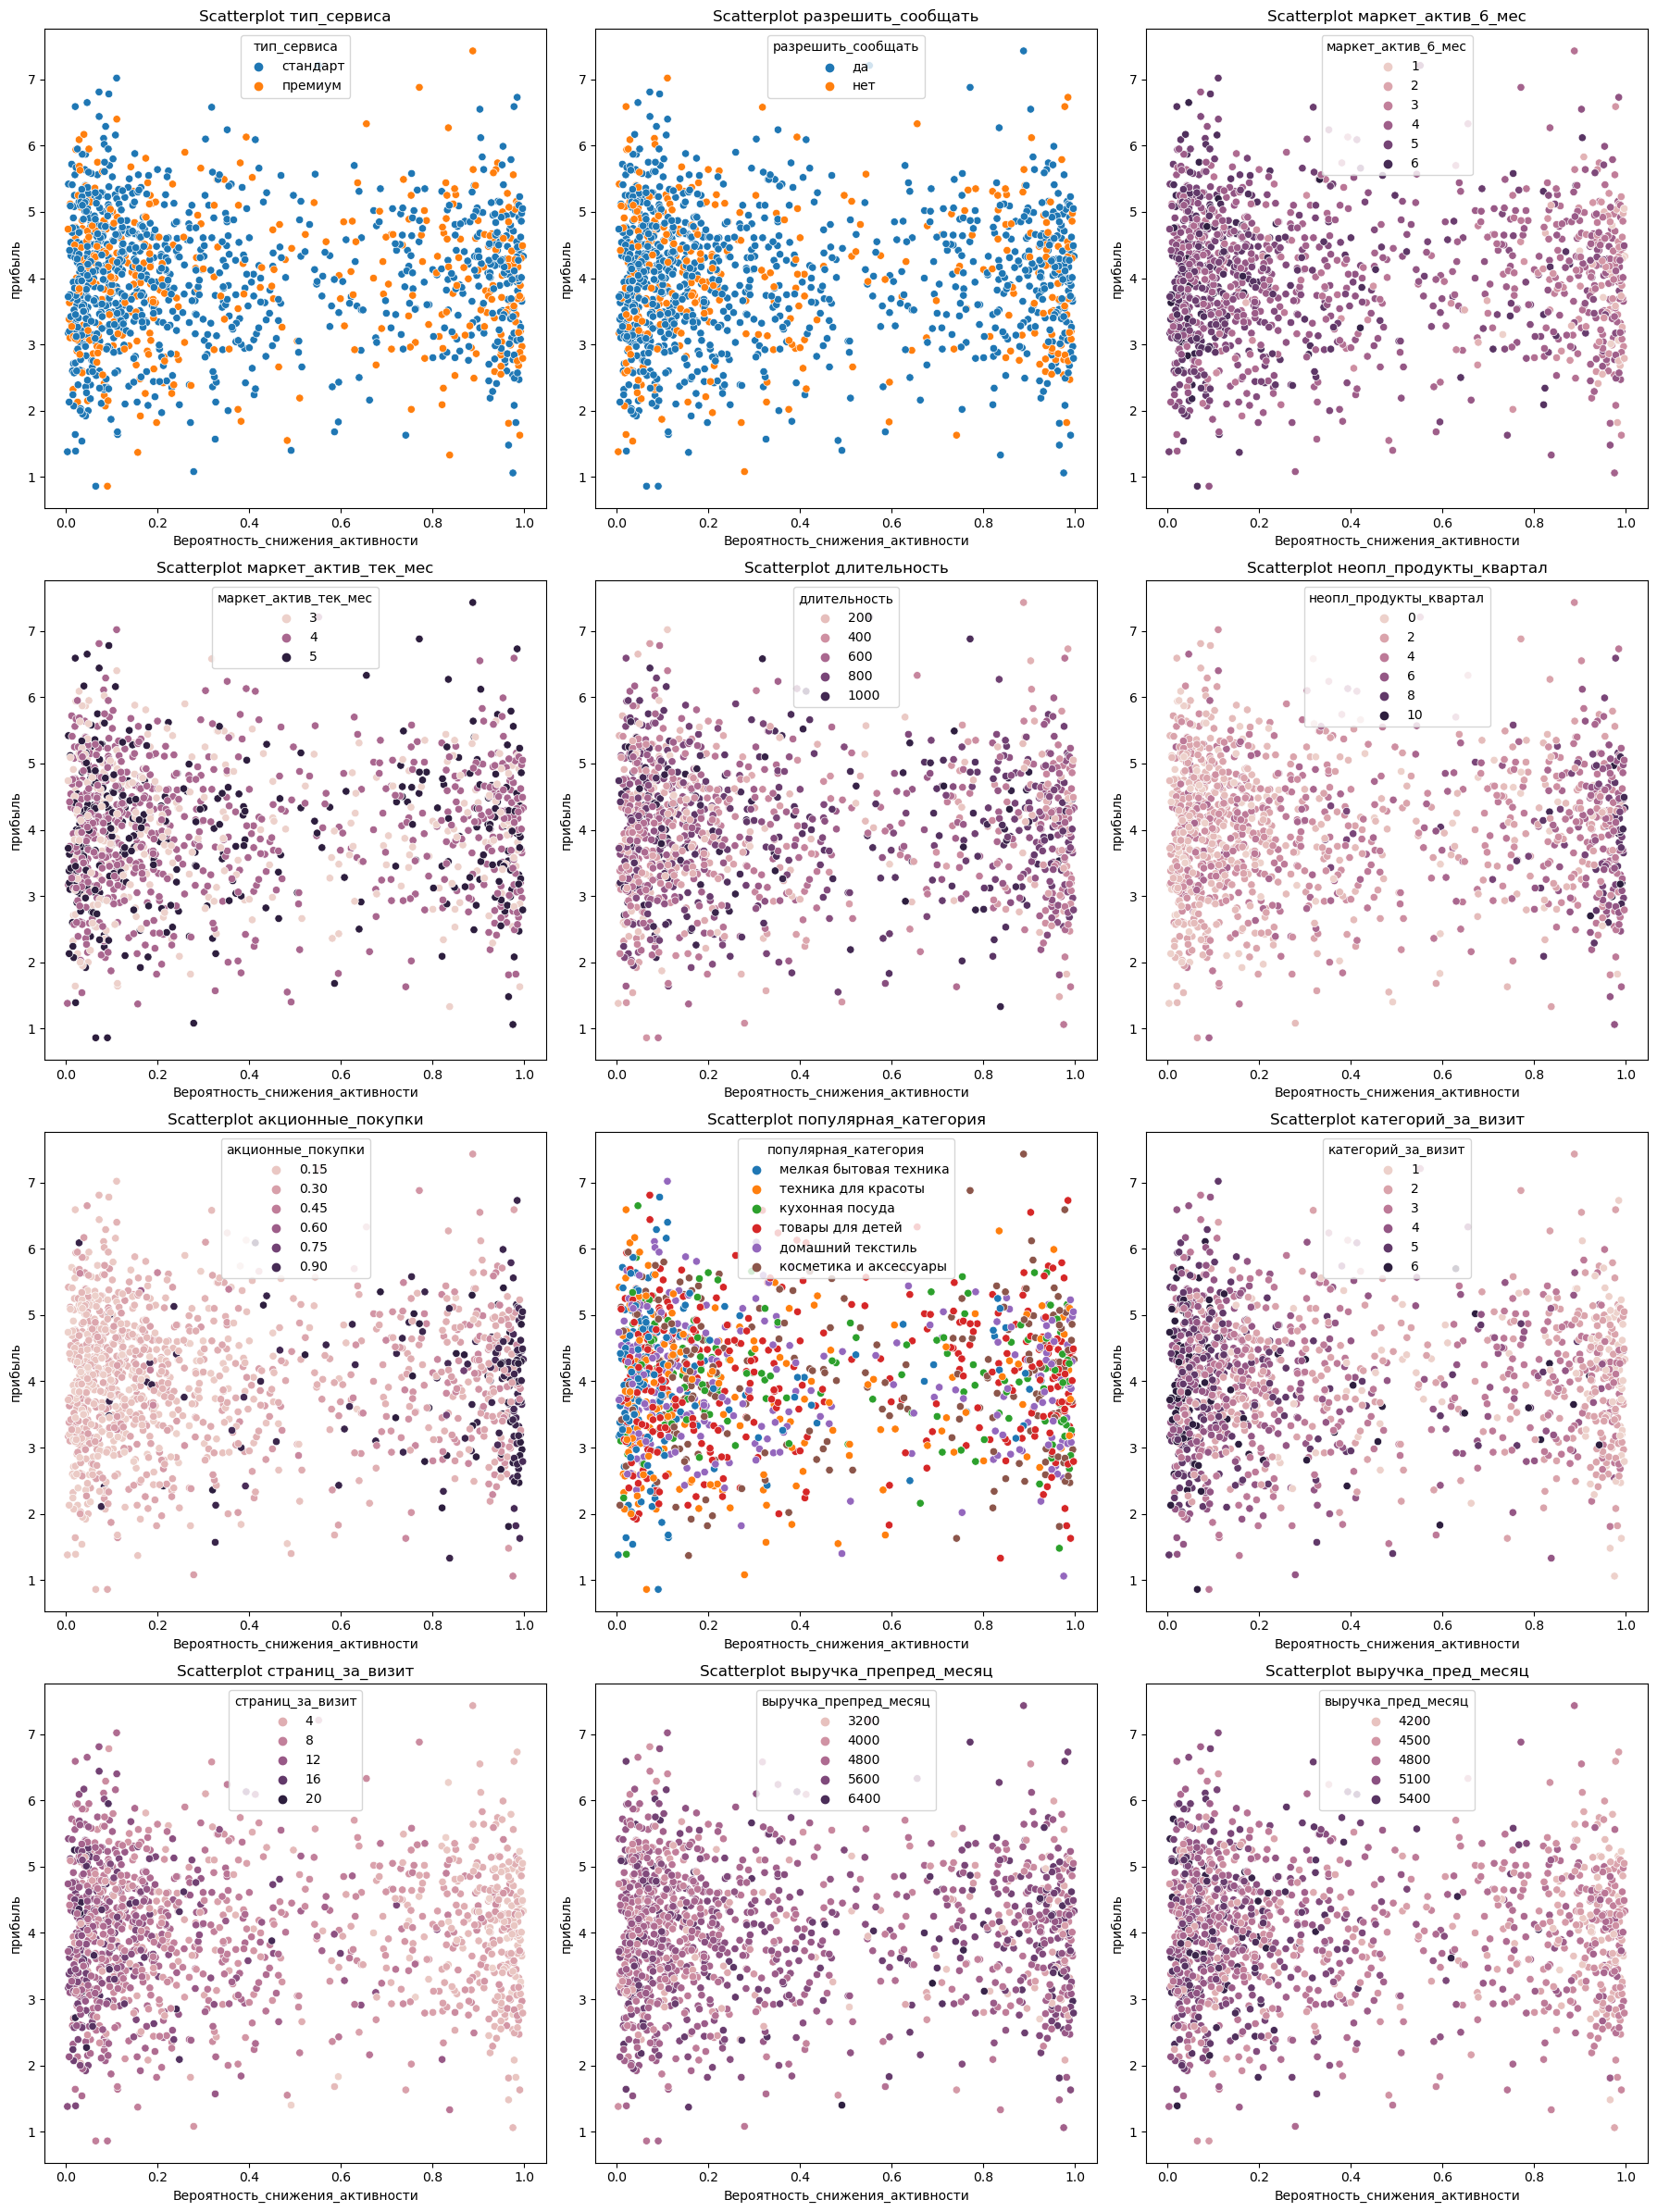

In [85]:
fig, axs = plt.subplots(4, 3, figsize=(18, 24))

scatterplot_vars = ['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес'
                    , 'маркет_актив_тек_мес', 'длительность', 'неопл_продукты_квартал'
                    , 'акционные_покупки', 'популярная_категория', 'категорий_за_визит'
                   , 'страниц_за_визит', 'выручка_препред_месяц', 'выручка_пред_месяц']



for i, var in enumerate(scatterplot_vars):
    row = i // 3
    col = i % 3
    sns.scatterplot(data=df_full, x="Вероятность_снижения_активности", y="прибыль", hue=var, ax=axs[row, col])
    axs[row, col].set_title(f"Scatterplot {var}")

plt.tight_layout()
plt.show()

 - **маркет_актив_6_мес**: мы видим, что с пользователи с 1 маркитенговой коммуникацией попадаю с выской веронятность в категорию снижения активности
 - **неопл_продукты_квартал**: мы видим, что пользователи с 8 и более неоплаченными продуктами попадают с высокой веронятностью в категорию снижения активности
 - **акционные_покупки**: люди с долей покупок по акции 90%, также попадают в снижение активности
 - **категорий_за_визит**: пользователи с 1 категорией визита попадают в снижение активности
 - **страниц_за_визит**: пользователи с 4 страницой визита попадают в снижение активности
 - **выручка_пред_месяц**: пользователи с наименьшей выручкой предыдущего месяца попадают в снижение активности

Изучим сегмент пользователей со сниженной активностью, который покупают только по акции. Из анализа данных мы поняли, что люди, покупающие только по акции являются отдельной категорией покупателей со своим нормальный распределнием. Также мы узнали, что как раз у этой категории падает активность, это наш целевой сегмент для исследования

#####  Выбор сегмента и анализ

In [86]:
# Отфильтруем данные по признаку Вероятность_снижения_активности и акционные покупки
df_filtered = df_full[(df_full['Вероятность_снижения_активности'] > 0.8) & (df_full['акционные_покупки'] > 0.8)]

df_filtered

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
215448     премиум                 да                 4.6   
215732    стандарт                нет                 3.5   
215537     премиум                 да                 3.9   
215741    стандарт                 да                 4.8   
215408     премиум                 да                 2.4   
...            ...                ...                 ...   
215521     премиум                нет                 1.5   
215701    стандарт                 да                 0.9   
215419     премиум                 да                 3.4   
215668     премиум                 да                 4.4   
215670    стандарт                 да                 4.1   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
215448                     4           974               0.94   
215732                     4           663               0.98   
215537                     4           705               0.99   
215741                     4           563               0.94   
215408                     3           666               0.98   
...                      ...           ...                ...   
215521                     3           541               0.90   
215701                     4           212               0.95   
215419                     4           806               0.93   
215668                     4           343               0.94   
215670                     4           490               0.98   

          популярная_категория  категорий_за_визит  неопл_продукты_квартал  \
id                                                                           
215448       домашний текстиль                   4                       3   
215732  косметика и аксессуары                   3                       6   
215537  косметика и аксессуары                   3                       3   
215741        товары для детей                   1                       5   
215408         кухонная посуда                   3                       5   
...                        ...                 ...                     ...   
215521        товары для детей                   2                       4   
215701       домашний текстиль                   2                       5   
215419       домашний текстиль                   3                       5   
215668        товары для детей                   2                       9   
215670         кухонная посуда                   3                       7   

        ошибка_сервиса  страниц_за_визит  выручка_препред_месяц  \
id                                                                
215448               3                 7                 5351.0   
215732               4                 3                 5810.0   
215537               7                 4                 6121.5   
215741               7                 4                 3960.0   
215408               1                 2                 5295.0   
...                ...               ...                    ...   
215521               4                 5                 4045.0   
215701               4                 2                 4685.5   
215419               8                 6                 5816.5   
215668               2                 2                 5567.5   
215670               3                 2                 5415.0   

        выручка_пред_месяц  выручка_тек_месяц  минуты_пред_месяц  \
id                                                                 
215448              4670.0             6129.7                  9   
215732              4955.0             5772.3                 16   
215537              4974.0             6781.9                  7   
215741              4809.0             4594.4                 10   
215408              4434.0             5029.8                 10   
... 

In [87]:
# #создадим список количественных признаков и сравним распределения df_filtered и df_full
# # создадим функцию для построения гистограмм
# def plot_overlay_histograms(df1, df2, numeric_columns):
#     for column in numeric_columns:
#         plt.figure(figsize=(10, 6))

#         # Гистограмма для первого датафрейма
#         sns.histplot(df1[column], bins=30, color='blue', alpha=0.5, kde=True, label='df_filtered')
        
#         # Гистограмма для второго датафрейма
#         sns.histplot(df2[column], bins=30, color='orange', alpha=0.5, kde=True, label='df_full')

#         plt.title(f'Гистограмма распределения для {column}')
#         plt.xlabel(column)
#         plt.ylabel('Частота')
#         plt.legend()
#         plt.show()

# # Используем числовые столбцы
# num_columns = ['маркет_актив_6_мес', 'длительность'
#                           , 'выручка_препред_месяц', 'выручка_пред_месяц', 'выручка_тек_месяц'
#                           , 'минуты_пред_месяц', 'минуты_тек_месяц', 'прибыль']
# plot_overlay_histograms(df_filtered, df_full, num_columns)

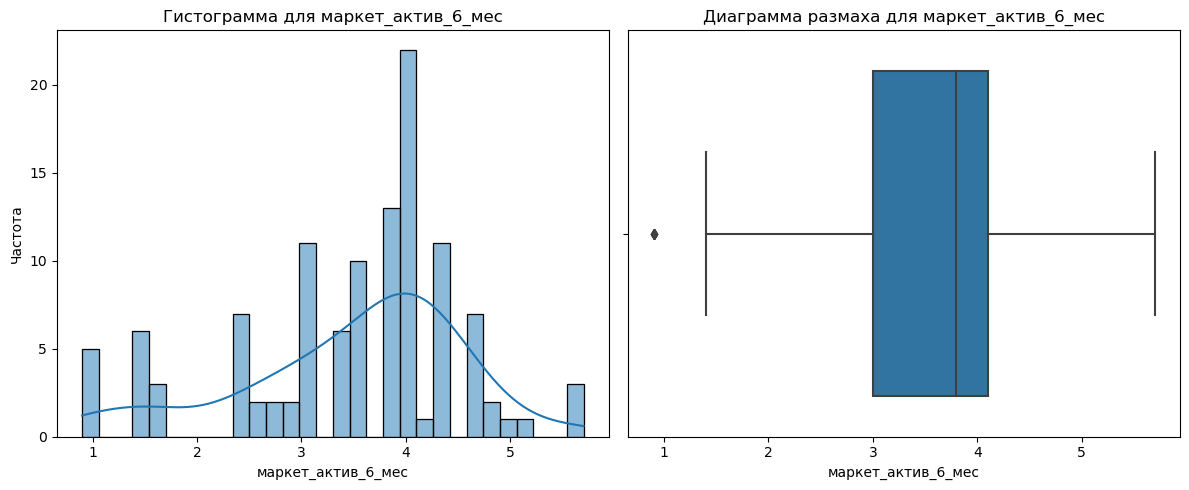

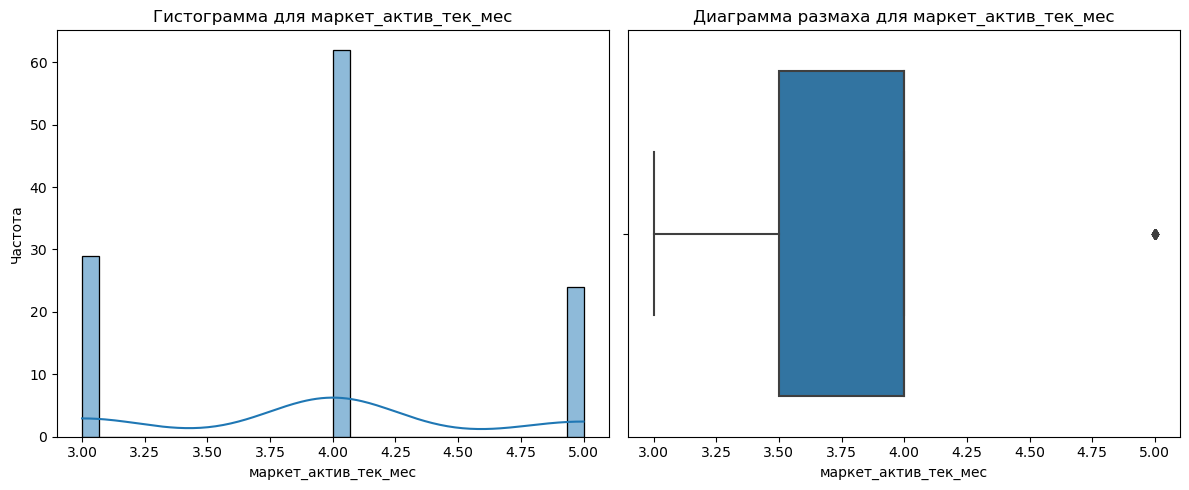

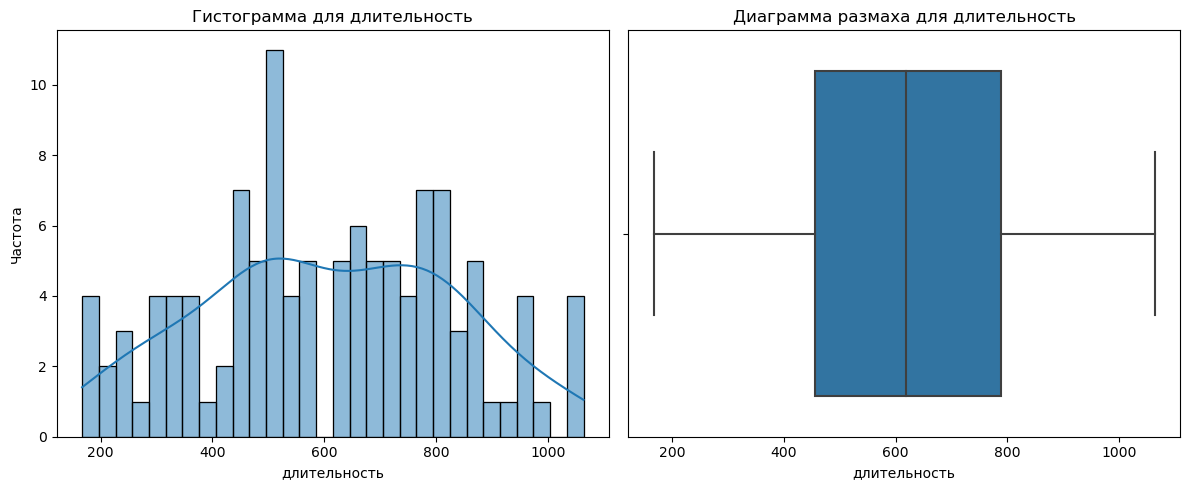

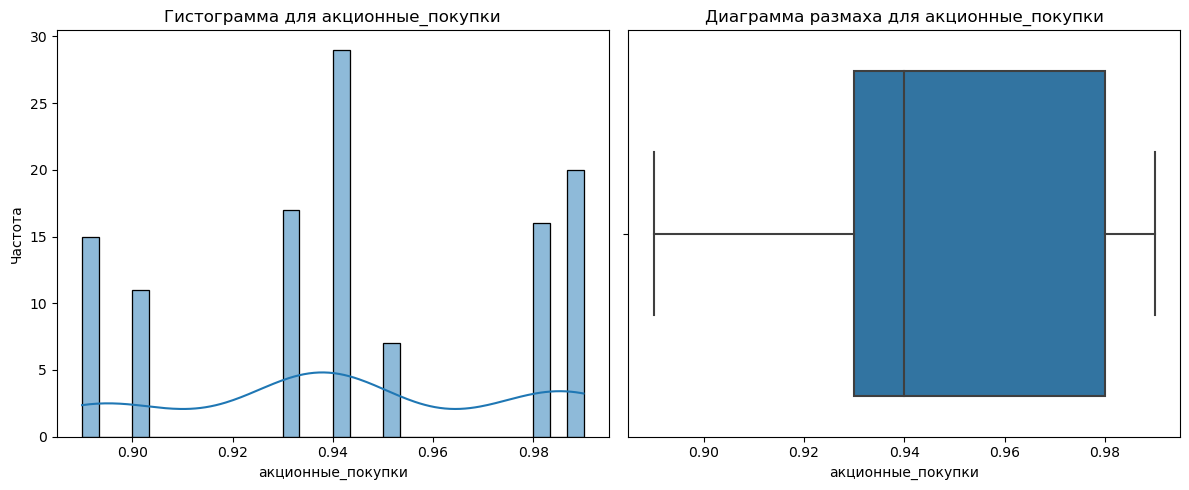

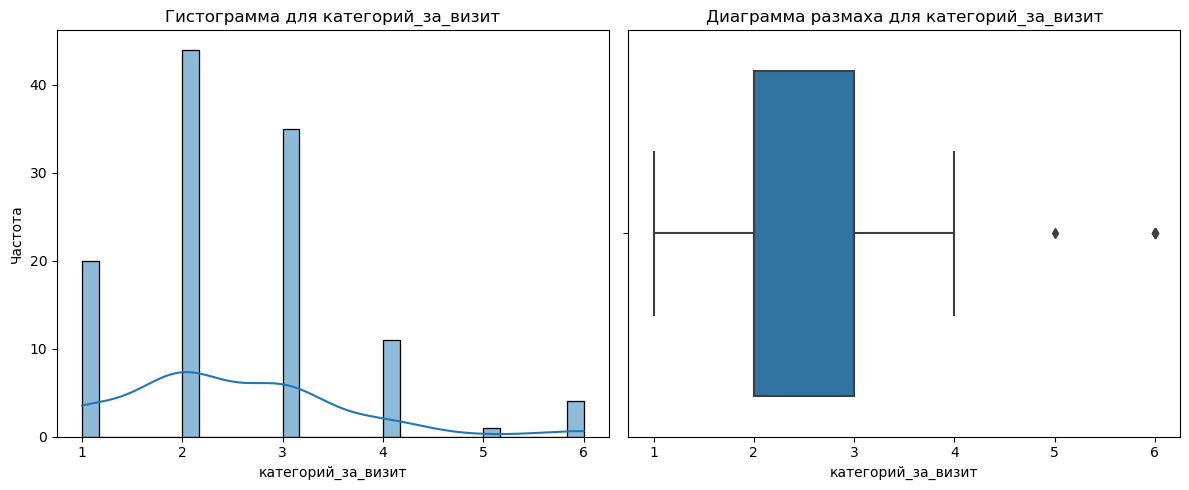

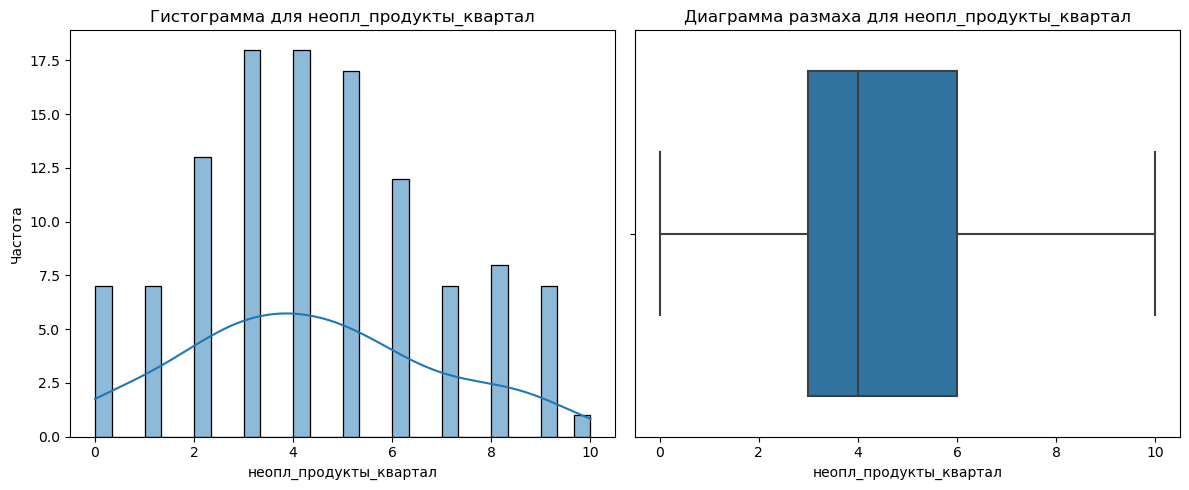

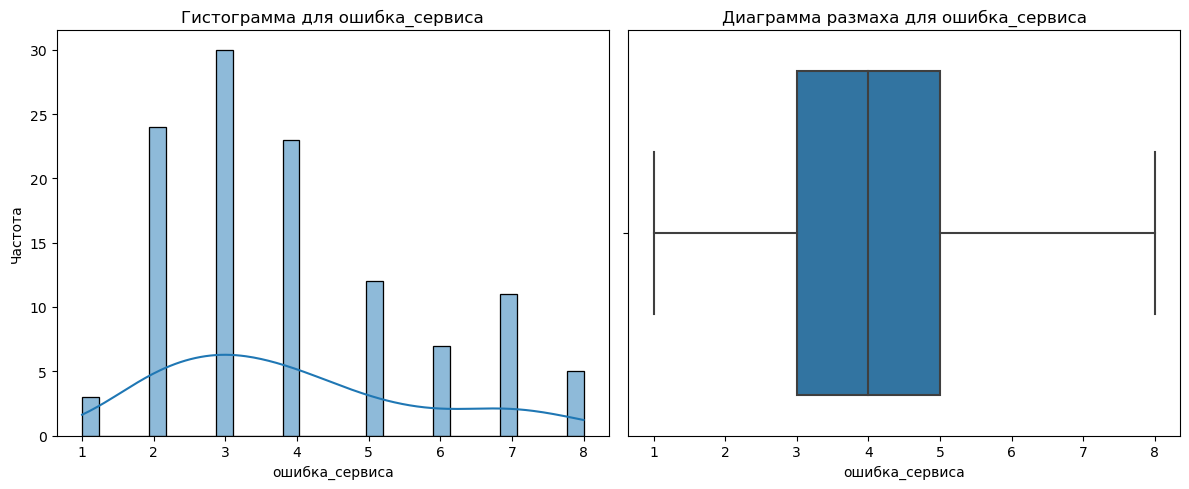

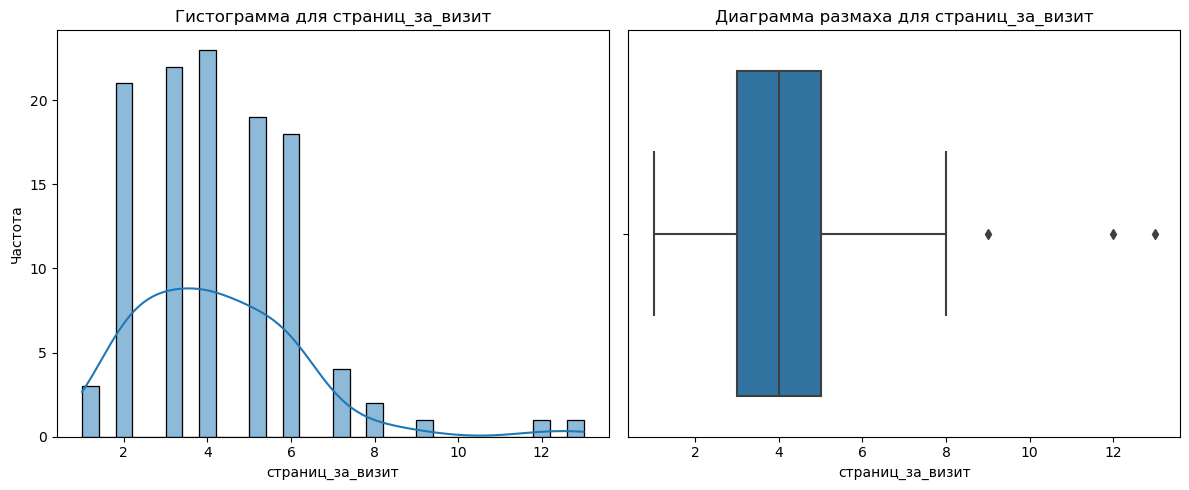

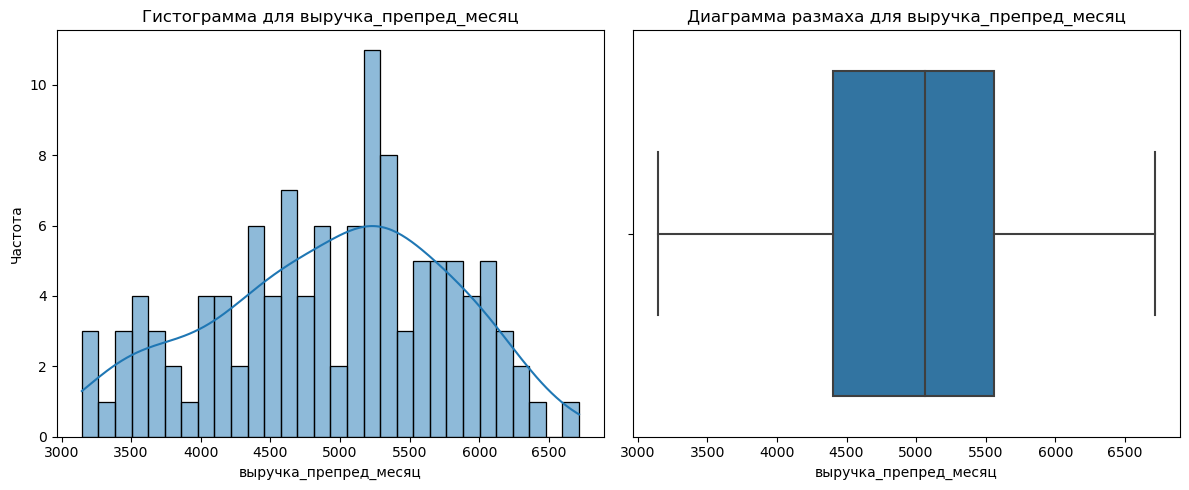

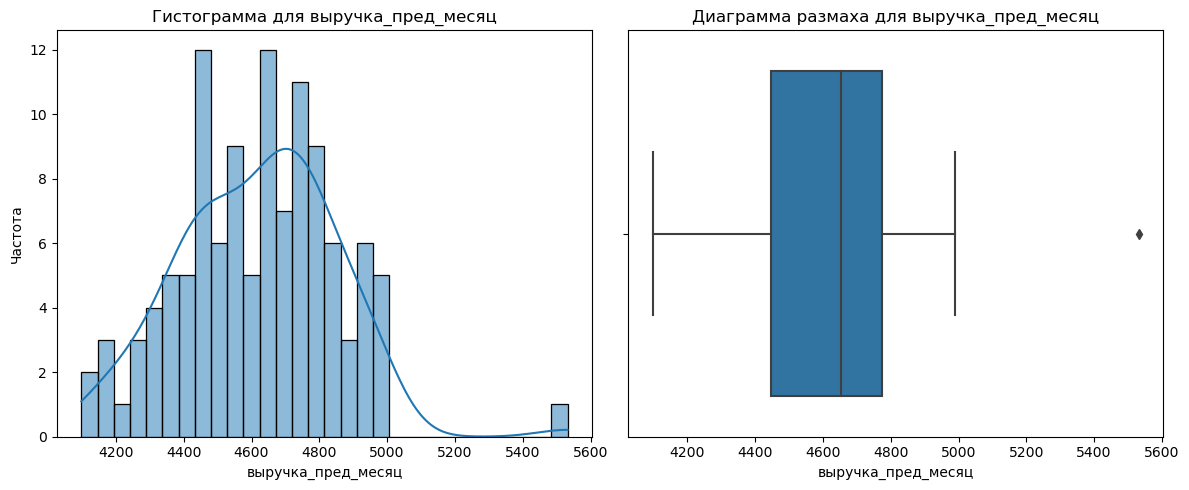

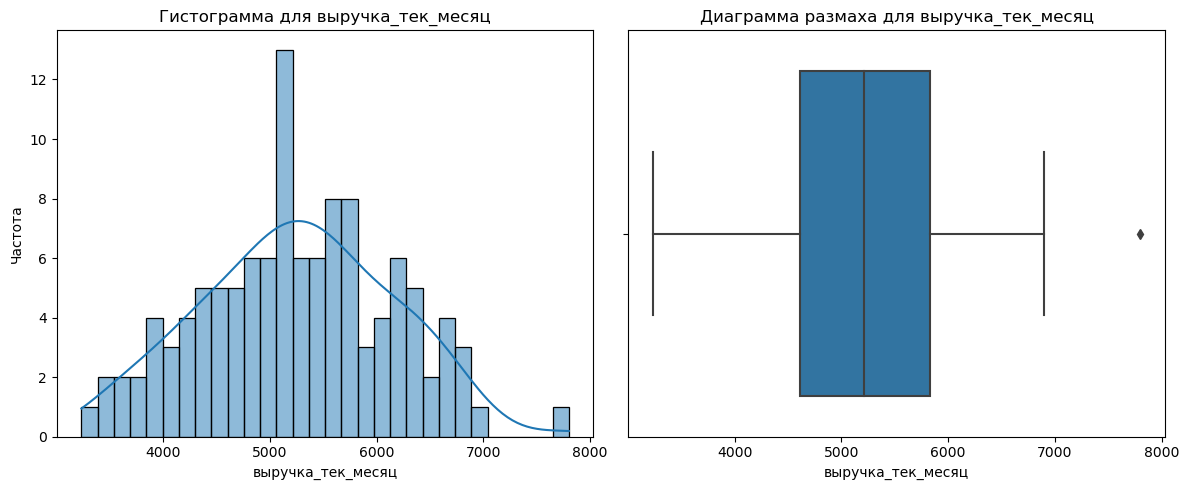

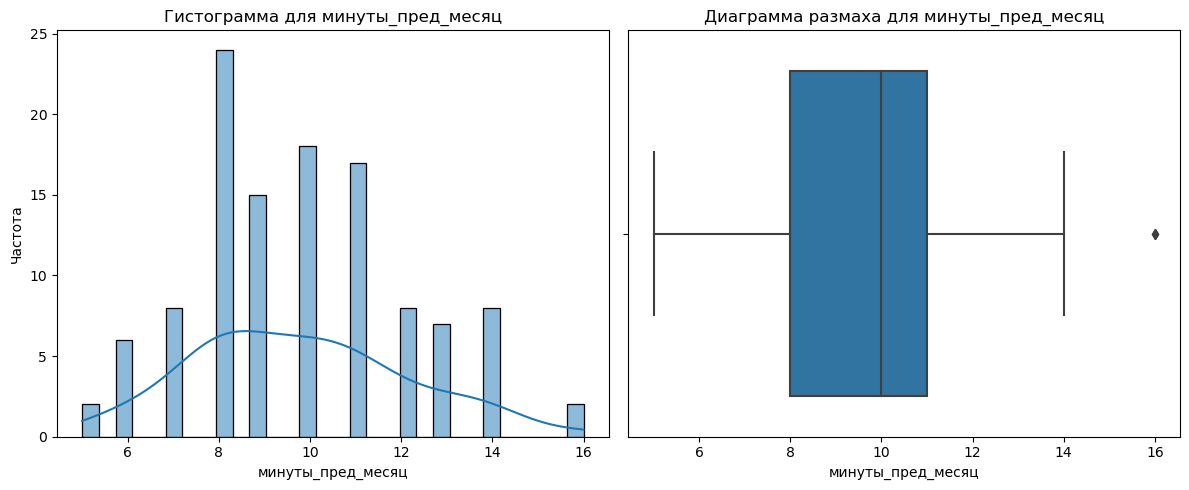

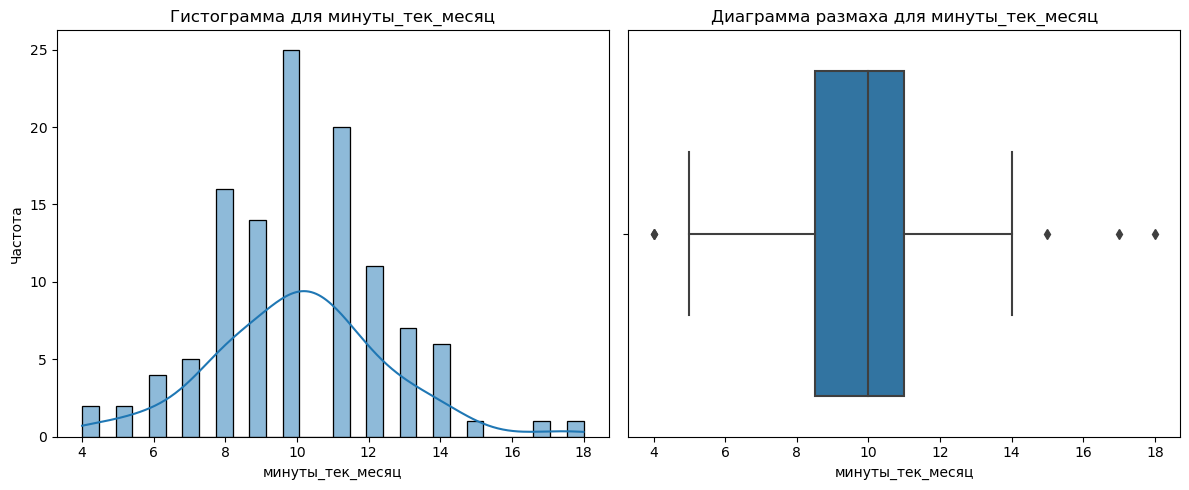

In [88]:
plot_histogram_and_boxplot(df_filtered, num_columns)

 **Выводы:**
 - **маркет_актив_6 _мес** видим, что у наш сегмент получил меньше внимания от маркетинга, и в среднем никто не получил 6 касаний за последние полгода
 - **длительность** данное распределение более менее равномерное
 - **выручка_пред_месяц** - в предыдущем месяце выручка упала у нашего сегмента. Нет сумм выше 5000 
 - **минуты пред_месяц и текущий_месяц** соответственно также упал, наш сегмент меньше проводит времени на сайте, среднеее время 10 минут


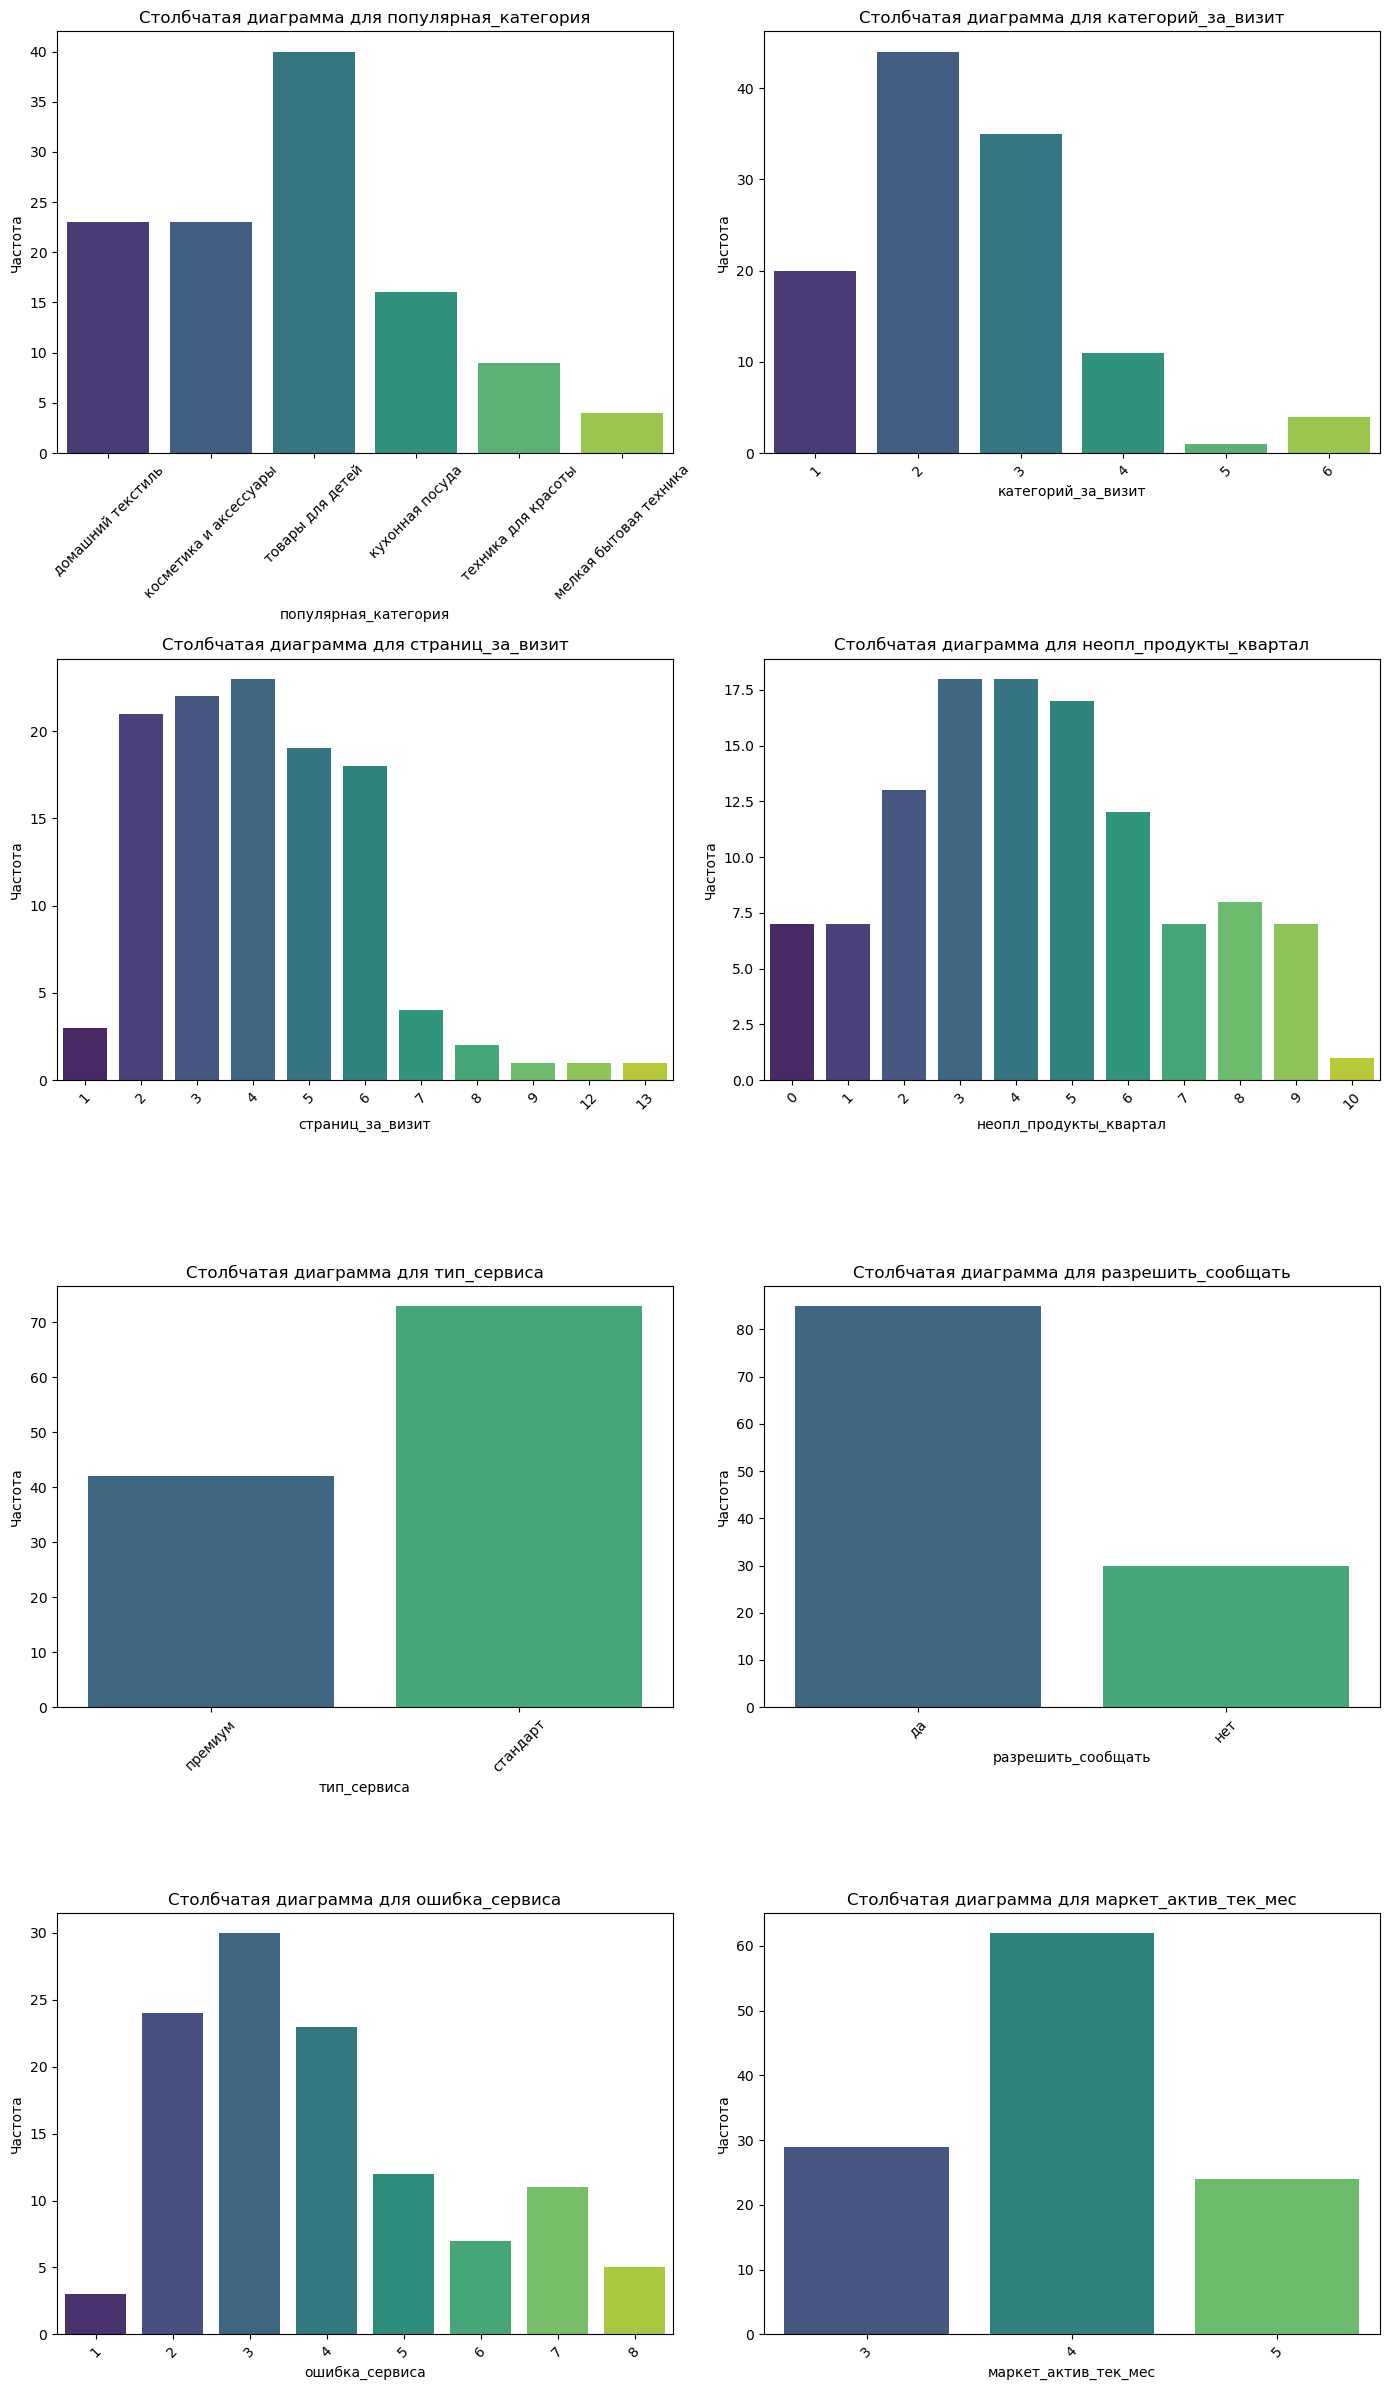

In [89]:
#создадим список категориальных признаков для df_filtered
cat_columns_df_filtered = ['популярная_категория', 'категорий_за_визит', 'страниц_за_визит'
                           , 'неопл_продукты_квартал', 'тип_сервиса', 'разрешить_сообщать'
                          ,'ошибка_сервиса', 'маркет_актив_тек_мес']
# построим столбчатые диаграммы для столбцов с категориальными признаками
plot_bar_charts(df_filtered, cat_columns_df_filtered)


**Выводы:**
 - **популярная_категория** попуярная категория для сегманта любетелей акций **товары для детей**
 - **категорий_за_визит** Просмотр 2 категорий за последние 3 месяца, что не очень хорошо
 - **страниц_за_визит** - Просмотре не более 6 страниц за последние 3 месяца для нашего сегмента 


По остальным категориям сложно сделать выводы, нужно сравнить данные с данными всех пользователей

In [90]:
df_filtered.head()

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
215448     премиум                 да                 4.6   
215732    стандарт                нет                 3.5   
215537     премиум                 да                 3.9   
215741    стандарт                 да                 4.8   
215408     премиум                 да                 2.4   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
215448                     4           974               0.94   
215732                     4           663               0.98   
215537                     4           705               0.99   
215741                     4           563               0.94   
215408                     3           666               0.98   

          популярная_категория  категорий_за_визит  неопл_продукты_квартал  \
id                                                                           
215448       домашний текстиль                   4                       3   
215732  косметика и аксессуары                   3                       6   
215537  косметика и аксессуары                   3                       3   
215741        товары для детей                   1                       5   
215408         кухонная посуда                   3                       5   

        ошибка_сервиса  страниц_за_визит  выручка_препред_месяц  \
id                                                                
215448               3                 7                 5351.0   
215732               4                 3                 5810.0   
215537               7                 4                 6121.5   
215741               7                 4                 3960.0   
215408               1                 2                 5295.0   

        выручка_пред_месяц  выручка_тек_месяц  минуты_пред_месяц  \
id                                                                 
215448              4670.0             6129.7                  9   
215732              4955.0             5772.3                 16   
215537              4974.0             6781.9                  7   
215741              4809.0             4594.4                 10   
215408              4434.0             5029.8                 10   

        минуты_тек_месяц  Вероятность_снижения_активности  прибыль  
id                                                                  
215448                10                         0.884661     2.95  
215732                11                         0.952754     3.51  
215537                 9                         0.965826     1.81  
215741                14                         0.960793     4.29  
215408                12                         0.987607     3.68

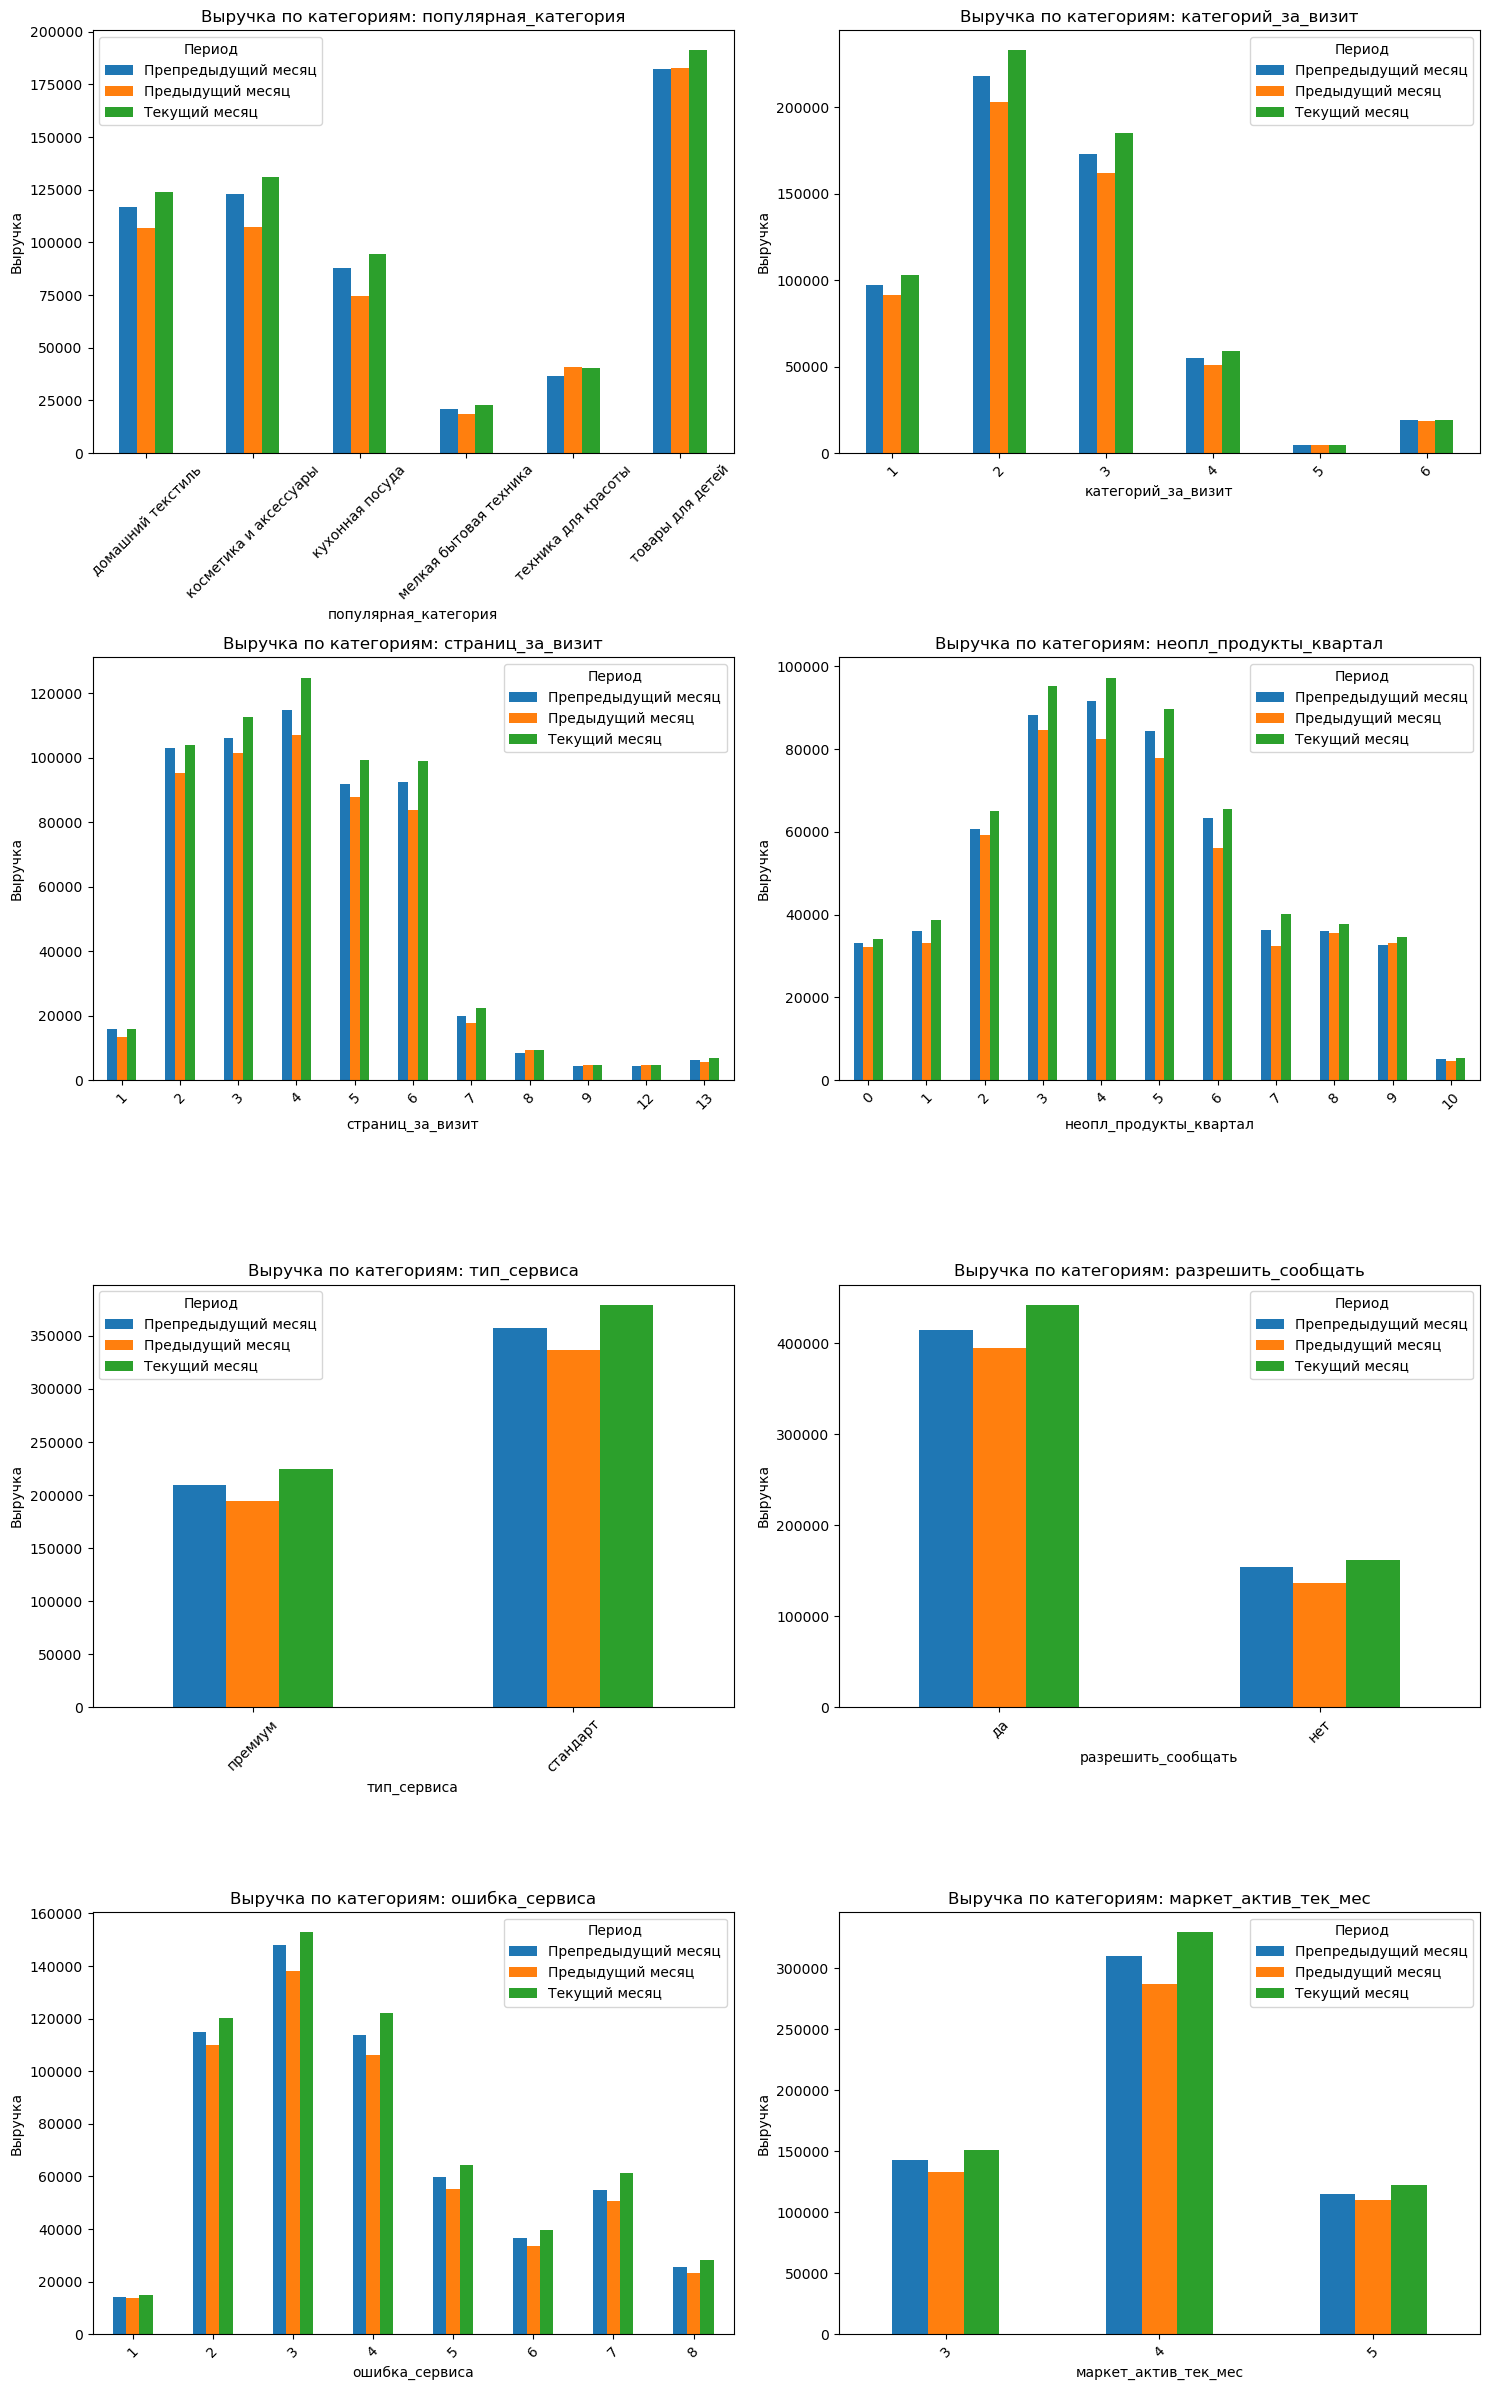

In [91]:
# Построим график выручки по категориям для 3х месяцев
def plot_revenue_by_category(df, category_columns):
    # Определяем количество подграфиков
    num_categories = len(category_columns)
    cols = min(num_categories, 2)  # Количество столбцов в ряду
    rows = (num_categories + cols - 1) // cols  # Количество строк, необходимое для всех категорий

    # Создаём фигуру с подграфиками
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
    axes = axes.flatten()  # Уплощаем массив подграфиков для простоты доступа 

    for i, category in enumerate(category_columns):
        # Группируем данные по категориальному столбцу
        revenue_by_category = df.groupby(category)['выручка_препред_месяц', 'выручка_пред_месяц', 'выручка_тек_месяц'].sum().reset_index()
        
        # Построим график на соответствующем подграфике
        revenue_by_category.plot(x=category, kind='bar', ax=axes[i])
        
        # Настраиваем заголовок и подписи
        axes[i].set_title(f'Выручка по категориям: {category}')
        axes[i].set_xlabel(category)
        axes[i].set_ylabel('Выручка')
        axes[i].set_xticklabels(revenue_by_category[category], rotation=45)
        axes[i].legend(title='Период', labels=['Препредыдущий месяц', 'Предыдущий месяц', 'Текущий месяц'])

    # Убираем пустые подграфики
    for j in range(num_categories, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Вызов функции для графиков по всем категориальным столбцам
plot_revenue_by_category(df_filtered, cat_columns_df_filtered)

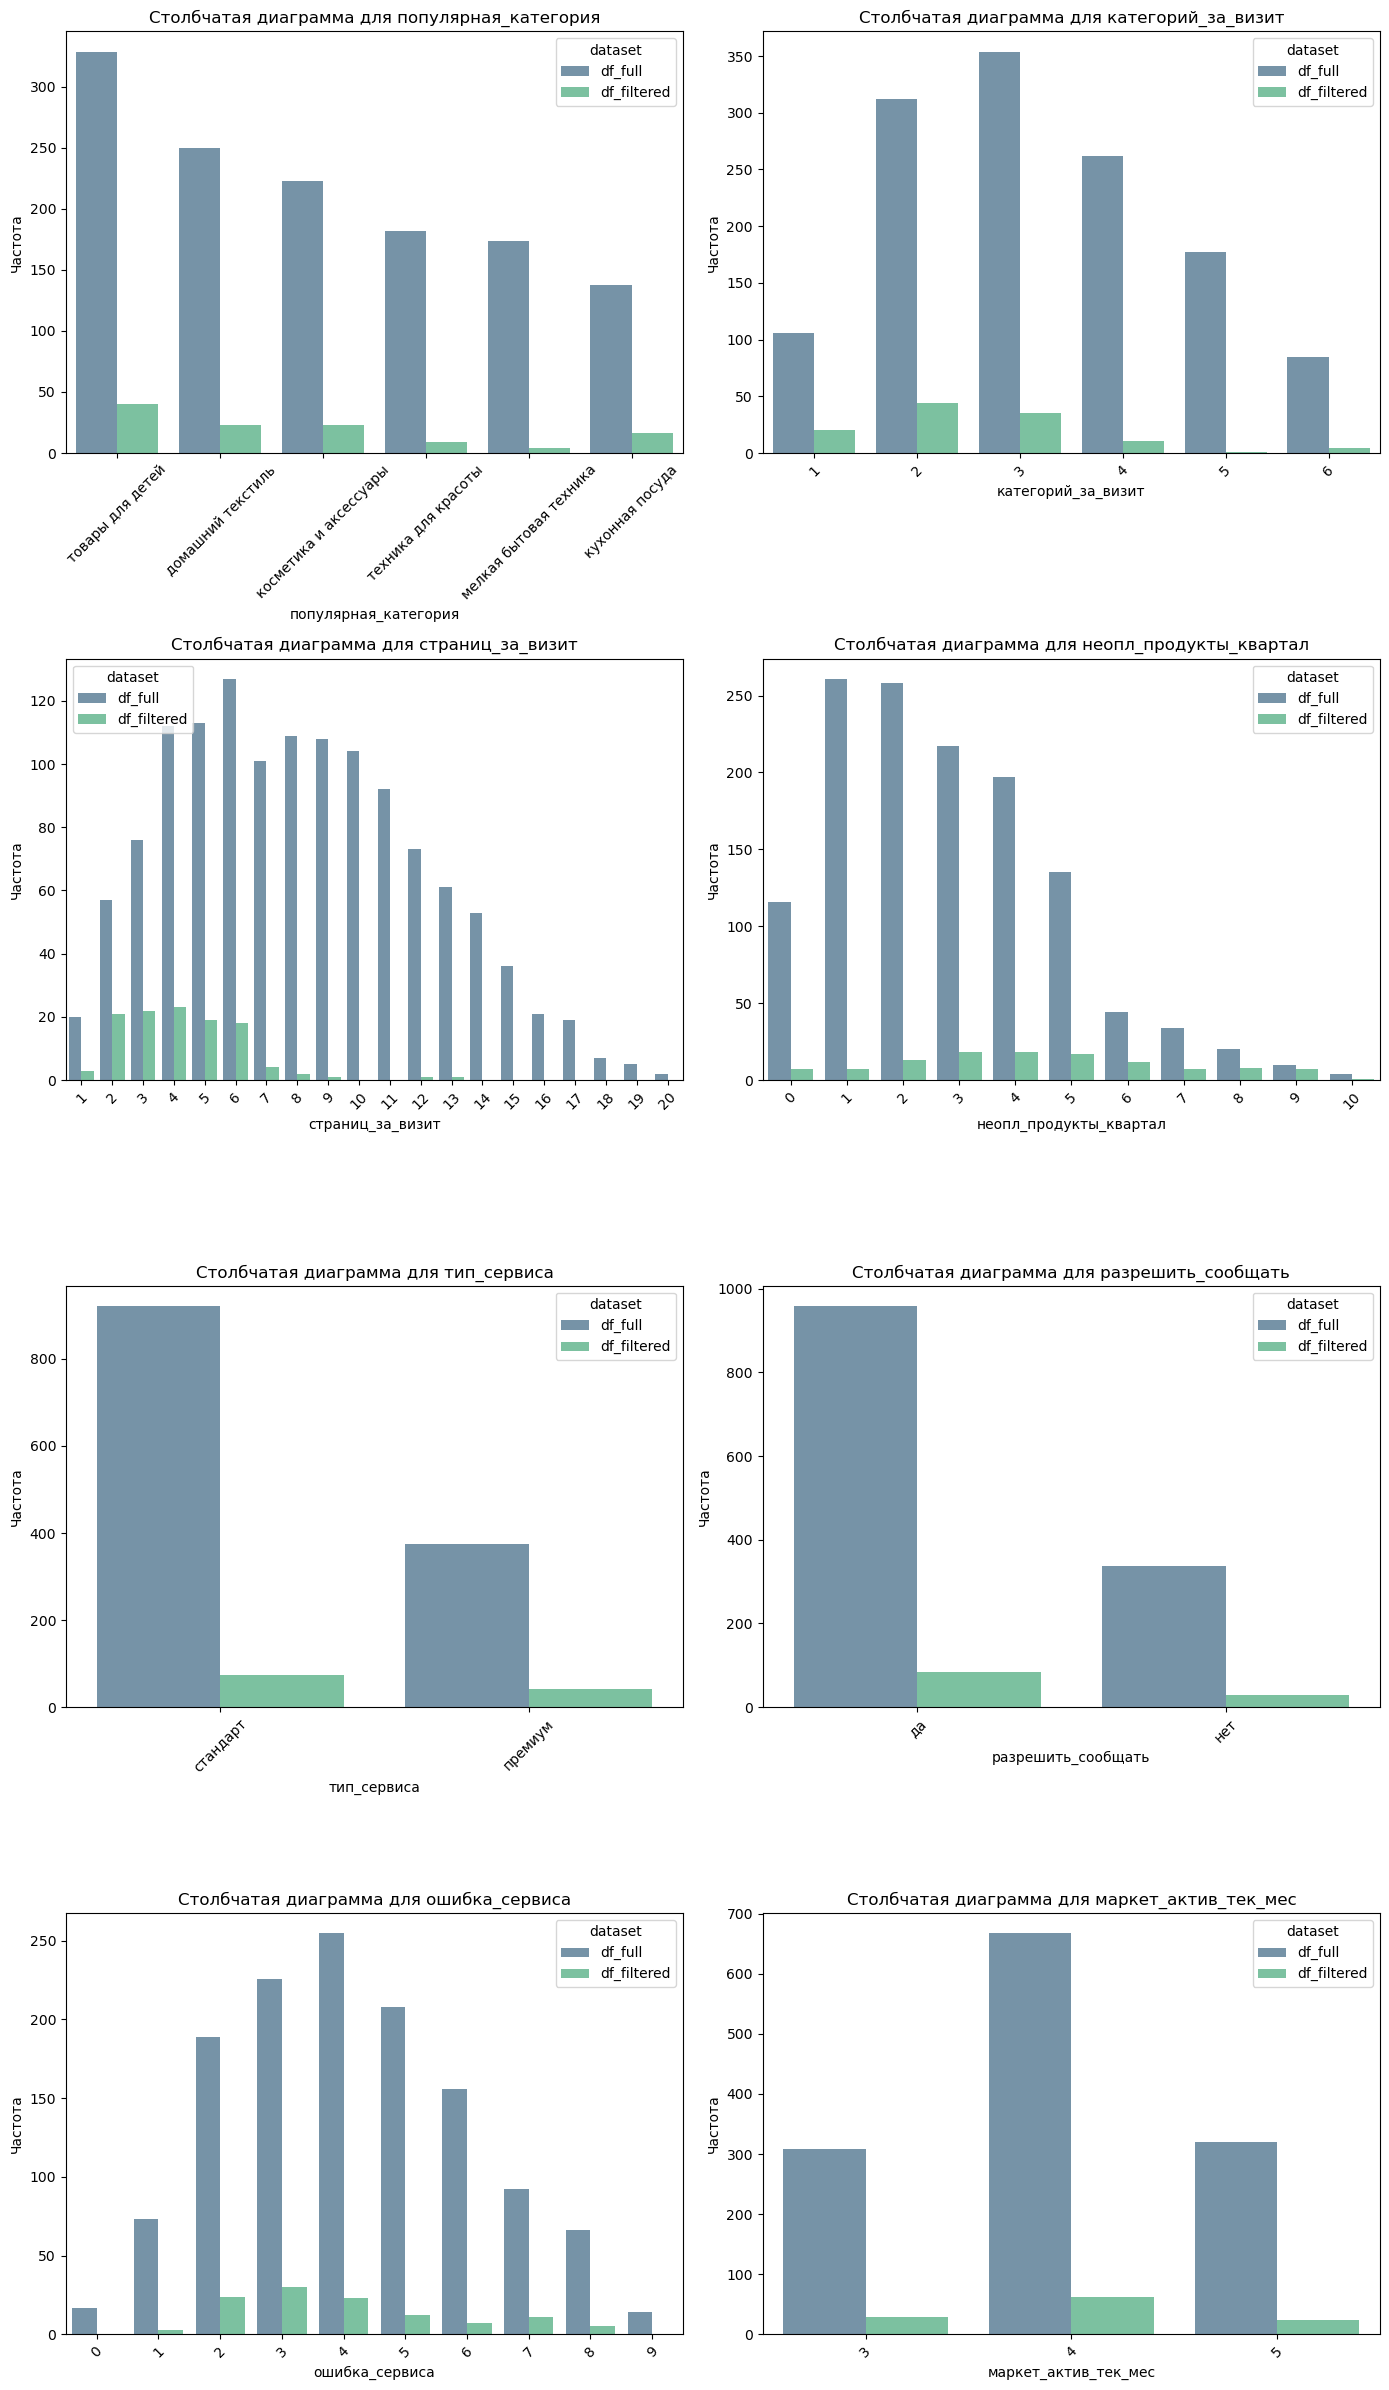

In [92]:
# А теперь сравним столбчатые диаграммы всех пользователей и нашего сегмента

def plot_overlay_bar_charts(df1, df2, categorical_columns):
    num_columns = len(categorical_columns)
    num_rows = (num_columns + 1) // 2  # Вычисление количества строк для подграфиков
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(14, 6 * num_rows))
    axes = axes.flatten()  # Преобразование массива осей в одномерный массив для удобства итерации
    
    for i, column in enumerate(categorical_columns):
        # Объединение данных с добавлением нового столбца для идентификации набора данных
        df1_agg = df1[column].value_counts().reset_index()
        df1_agg.columns = [column, 'count']
        df1_agg['dataset'] = 'df_full'
        
        df2_agg = df2[column].value_counts().reset_index()
        df2_agg.columns = [column, 'count']
        df2_agg['dataset'] = 'df_filtered'
        
        combined_data = pd.concat([df1_agg, df2_agg])
        
        # Построение наложенной столбчатой диаграммы
        sns.barplot(data=combined_data, x=column, y='count', hue='dataset', palette='viridis', ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Столбчатая диаграмма для {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Частота')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    
    # Удаление пустых подграфиков, если количество категориальных столбцов нечетное
    if num_columns % 2 != 0:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
categorical_columns = ['популярная_категория', 'категорий_за_визит', 'страниц_за_визит'
                           , 'неопл_продукты_квартал', 'тип_сервиса', 'разрешить_сообщать'
                          ,'ошибка_сервиса', 'маркет_актив_тек_мес']
plot_overlay_bar_charts(df_full, df_filtered, categorical_columns)

**И так, выводы по нашему сегменту:**
 - **маркет_актив_6 _мес** видим, что у наш сегмент получил меньше внимания от маркетинга, и в среднем никто не получил 6 касаний за последние полгода
 - **выручка_пред_месяц** - в предыдущем месяце выручка упала у нашего сегмента по сравнению в общим кол-во. Нет сумм выше 5000 
 - **минуты пред_месяц и текущий_месяц** соответственно также упал, наш сегмент меньше проводит времени на сайте
 - **популярная_категория** попуярная категория для сегмента любителей акций **товары для детей**, но эти данные походи не поведение всех пользователей
 - **категорий_за_визит** Просмотр 2 категорий за последние 3 месяца, что не очень хорошо, кол-во категорий меньше, чем у всех пользователей, что тоже меньше, чем у всех
 - **неопл_продукты_квартал** Наш сегмент имеет больше неоплаченных продуктов за квартал
 - **страниц_за_визит** - Просмотре не более 6 страниц за последние 3 месяца для нашего сегмента, что конечно же меньше, чем у всех

Остальные признаки не имеют особого значения.

**Рекомендации**

На основании изученных данных можно сделать следущие рекомендации:
 - Отслеживать марткетинговую актвиность, а контролировать рассылки для нашего сегмента т.к. он получает меньше внимания, хотя также как и все согласен получать рассылки
 - Разработать схему "дожима" клиентов, которые имеют большое кол-во неоплаченных товаров. Если есть приложение, то отправлять пуш-уводмление с напоминаем: изменения цены или товар скоро закончится. Или придумать доп условия на увеличенное кол-во неоплаченных товаров: Купите 3 и более товаров получите бесплатную дсотавку или расширенное серисное обслуживание. Зависит от того, что компания может предложить. Возможно предложить рассрочку
 - Подробно изучить поведения клиентов на сайте, чтобы они больше проводили времени на страницах и больше смотрели категорий. Возможна есть проблема с юзабилити и они просто не понмают, как перети в другую категорию или не настроены фильтры выбора товаров. Т.к. страниц за визит и категории за визит являются самыми главными признаками потери активности пользователей. 
 - И т.к. наш сегмент покупает только по акции, а потом становится неактивным, получается что эту категорию клиетов привлекли по отдельной рекламной компании, связанойсо скидками, сейчас они купили и потеряли интерес. Возможно для таких клиентов стоит сделать отдельную страницу на сайте с текущими спецпрдложениями на сайте, также мы понимаем, что они не любят смотреть много категорий  и страниц, значит этот раздел должен быть доступен с главной страницы и с удобными настройками фильтрации. Такой клиент должен понимать, что ему еще есть что купить по акции.  
 - Также, думаю стоит пересмотреть акционную систему на сайте. Разработать прогрессивную шкалу. Добавить категории пользователей с лучшими условиями например: Золотой, серебряный, бронзовый. Помими скидок необходимо использовать другие инструменты вовлеченности пользователей, используя другие психологические качества: купи сейчас, разбей платежи, купи еще и получи дополнительную медальку, получи бесплатное обслуживание


#### Этап 9. Общий вывод
Сделайте общий вывод:
опишите задачу;
опишите исходные данные и проведённую предобработку;
напишите, что вы сделали для поиска лучшей модели;
укажите лучшую модель;
добавьте выводы и дополнительные предложения для выбранного сегмента покупателей.

 - Интернет-магазин «В один клик» поставил задачу изучить данные о покупателях т.к. они беспокоятся о том, что теряют активность постоянных покупателей. Рукодоство компании хочет получить отчет о факторых влияющий на активность покупаталей и рекомендации на основе анализа данных и построении модели машинного обучения, чтобы иметь возможность принять решение, как меньше терять постоянных покупателей.

- Исходные данные были получены в 4 таблицах: market_file.csv, market_money.csv, market_time.csv, money.csv. Была проведена обработка данных. В целом можно похвалить аналитиков компании за чество предоставленных данных т.к. компания внимательно собирает данные.  Мы изменили названия стобцов и привели их к единому стандарту, проверили категориальные значения, устранили неявные дубликаты и орфографические ошибки
- Был проведен исследовательский анализ данных. Изучены распределения данных и их выбросы. Уже на этом этапе были отчечены некоторые интересные детали: есть пользователи, которые покупают только по акции, есь пользователи, которые получает меньше коммуникации на 6 месяцев. Активность снизалась у 500 пользователей, что примерно 38% от общего кол-ва пользователей.
- На этапе корреляционного анализа данных, мы изучили как признаки влияют друг на друга, мультиколлинеарности не было обнаружено, также особо высоких зависимостей не было.
- Для поиска лучше модели мы настроили и использовали пайплайн с 4 моделями: DecisionTreeClassifier(), KNeighborsClassifier(), SVC(), LogisticRegression() с перебором гиперпараметров. Мы использовали GridSearchCV для поиска лучшей модели.
- Лучшей моделью стала LogisticRegression() с параметрами: (C=1, penalty='l1', random_state=42, solver='liblinear'), на тренировочной выборке показатель ROC-AUC = 0.8984, на тестовой показатель ROC-AUC = 0.9182. Что является хорошим результатом. 
- с помощью SHAP метода удалось показать важные признаки для лучшей модели: кол-во просмотренных страницза визит, кол-во просмотренных категорий, и проведенные минуты на сайте. 
- Мы выделили сегмент пользователей покупающих только по акции и теряющих активность, сравнили его со всем пользователями. Сформулировали следующие рекомендации для улучшения активности:
 1. Отслеживать марткетинговую актвиность, а контролировать рассылки для нашего сегмента т.к. он получает меньше внимания, хотя также как и все согласен получать рассылки
 2. Разработать схему "дожима" клиентов, которые имеют большое кол-во неоплаченных товаров. Если есть приложение, то отправлять пуш-уводмление с напоминаем: изменения цены или товар скоро закончится. Или придумать доп условия на увеличенное кол-во неоплаченных товаров: Купите 3 и более товаров получите бесплатную дсотавку или расширенное серисное обслуживание. Зависит от того, что компания может предложить. Возможно предложить рассрочку
 3. Подробно изучить поведения клиентов на сайте, чтобы они больше проводили времени на страницах и больше смотрели категорий. Возможна есть проблема с юзабилити и они просто не понмают, как перети в другую категорию или не настроены фильтры выбора товаров. Т.к. страниц за визит и категории за визит являются самыми главными признаками потери активности пользователей. 
 4. И т.к. наш сегмент покупает только по акции, а потом становится неактивным, получается что эту категорию клиетов привлекли по отдельной рекламной компании, связанойсо скидками, сейчас они купили и потеряли интерес. Возможно для таких клиентов стоит сделать отдельную страницу на сайте с текущими спецпрдложениями на сайте, также мы понимаем, что они не любят смотреть много категорий  и страниц, значит этот раздел должен быть доступен с главной страницы и с удобными настройками фильтрации. Такой клиент должен понимать, что ему еще есть что купить по акции.  
 5.Также, думаю стоит пересмотреть акционную систему на сайте. Разработать прогрессивную шкалу. Добавить категории пользователей с лучшими условиями например: Золотой, серебряный, бронзовый. Помими скидок необходимо использовать другие инструменты вовлеченности пользователей, используя другие психологические качества: купи сейчас, разбей платежи, купи еще и получи дополнительную медальку, получи бесплатное обслуживание
 
конец :-)